# Setup and Preparation

In [1]:
!nvidia-smi

Tue Jun  2 07:58:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Package Download and Installation

In [0]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install unidecode
!pip install --upgrade nltk
!pip install --upgrade torchtext
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip install git+https://github.com/Maluuba/nlg-eval.git@master

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144791 sha256=81e0ec207ae47ad34691f0ca41341848df47a07d927cb1e9f98aa3372e6452cf
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein
     |████████████████████████████████| 245kB 2.7MB/s 
     |████████████████████████████████| 1.4MB 2.7MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434675 sha256=8fd0a8e34a6926c324ca5e1734b8f3c1bce44b2634ecccf0433b6df871b78c71
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 1.1MB 6.6MB/s 
  Fo

In [0]:
!export NLGEVAL_DATA='/content/drive/My Drive/TA/.cache/nlgeval'
!nlg-eval --setup '/content/drive/My Drive/TA/.cache/nlgeval'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Installing to /content/drive/My Drive/TA/.cache/nlgeval
In case of incomplete downloads, delete the directory and run `nlg-eval --setup /content/drive/My Drive/TA/.cache/nlgeval' again.
glove2word2vec.py: 100% 1.00/1.00 [00:00<00:00, 614 chunks/s]
multi-bleu.perl: 100% 1.00/1.00 [00:00<00:00, 559 chunks/s]


In [0]:
import sys
import string
import time
import math
import random
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
# nltk.download('wordnet')

from gensim.models.fasttext import FastText

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from warmup_scheduler import GradualWarmupScheduler

from nlgeval import NLGEval

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE_PATH = '/content/drive/My Drive/TA/'

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loads Indonesian FastText Model

In [0]:
model = FastText.load_fasttext_format(f'{BASE_PATH}models/word-embedding/cc.id.300.bin')

EMBEDDING_SIZE = len(model.wv['a'])
print(EMBEDDING_SIZE)
print(len(model.wv.vocab))

300
2000000


In [0]:
i = 0
for key, _ in model.wv.vocab.items():
    print(key)
    i += 1
    if i > 10: break

,
.
</s>
yang
dan
"
di
)
(
dengan
dari


In [0]:
print("algoritmatik" in model.wv.vocab)
# print(model.wv.most_similar("algoritmatik"))

False


## Loading Data

In [0]:
SQUAD_TRAIN_DATASET_PATH = f'{BASE_PATH}data/processed/train-v2.0-translated_fixed_enhanced.json'
SQUAD_TEST_DATASET_PATH = f'{BASE_PATH}data/processed/dev-v2.0-translated_fixed_enhanced.json'

df_squad = pd.read_json(SQUAD_TRAIN_DATASET_PATH)
df_squad_test = pd.read_json(SQUAD_TEST_DATASET_PATH)
print(df_squad.shape)
print(df_squad)
print(df_squad_test.shape)
print(df_squad_test)

(442, 2)
                                           title                                         paragraphs
0                                        Beyonce  [{'qas': [{'question': 'Kapan Beyonce mulai me...
1                                Frédéric Chopin  [{'qas': [{'question': 'Bagaimana kewarganegar...
2    Hubungan Tiongkok-Tibet selama dinasti Ming  [{'qas': [{'question': 'Siapakah Wang Jiawei d...
3                                           IPod  [{'qas': [{'question': 'Perusahaan mana yang m...
4         The Legend of Zelda: Twilight Princess  [{'qas': [{'question': 'Apa kategori game Lege...
..                                           ...                                                ...
437                                      Infeksi  [{'qas': [{'question': 'Dari sejumlah besar mi...
438                                      Berburu  [{'qas': [{'question': 'Apa praktik membunuh a...
439                                    Kathmandu  [{'qas': [{'question': 'Negara mana Kathm

In [0]:
# TAKEN_DATA_INDEX = 288

# df_squad = df_squad[df_squad.index <= TAKEN_DATA_INDEX]
print(df_squad.iloc[-1]['paragraphs'][-1].get('entities'))
print(df_squad.iloc[-1]['paragraphs'][-1].get('postags'))

[]
[[['Istilah', 'NNO'], ['"', 'PUN'], ['materi', 'NNO'], ['"', 'PUN'], ['digunakan', 'VBP'], ['di', 'PPO'], ['seluruh', 'KUA'], ['fisika', 'NNO'], ['dalam', 'PPO'], ['beragam', 'KUA'], ['konteks', 'NNO'], ['yang', 'PRR'], ['membingungkan', 'VBT'], [':', 'PUN'], ['misalnya', 'ADV'], [',', 'PUN'], ['seseorang', 'PRN'], ['merujuk', 'VBT'], ['pada', 'PPO'], ['"', 'PUN'], ['fisika', 'NNO'], ['benda', 'NNO'], ['terkondensasi', 'VBP'], ['"', 'PUN'], [',', 'PUN'], ['"', 'PUN'], ['materi', 'NNO'], ['dasar', 'NNO'], ['"', 'PUN'], [',', 'PUN'], ['"', 'PUN'], ['materi', 'NNO'], ['partonik', 'NNO'], ['"', 'PUN'], [',', 'PUN'], ['"', 'PUN'], ['materi', 'NNO'], ['gelap', 'ADJ'], ['"', 'PUN'], [',', 'PUN'], ['"', 'PUN'], ['anti', 'VBT'], ['"', 'PUN'], ['-', 'PUN'], ['matter', 'NNO'], [',', 'PUN'], ['"', 'PUN'], ['"', 'PUN'], ['materi', 'NNO'], ['"', 'PUN'], ['dan', 'CCN'], ['"', 'PUN'], ['nuklir', 'NNO'], ['"', 'PUN'], ['yang', 'PRR'], ['aneh', 'ADJ'], ['.', 'PUN'], ['Dalam', 'PPO'], ['diskusi', 'NNO

## Delete Unfound Answers from Dataset

In [0]:
def delete_unfound_answers(df_squad):
    total_questions_before = 0
    total_questions = 0
    for taken_topic_idx in range(df_squad.shape[0]):
        for taken_context_idx in range(len(df_squad.iloc[taken_topic_idx]['paragraphs'])):
            i = 0
            qas = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_context_idx]['qas']
            while i < len(qas):
                total_questions_before += 1
                indonesian_answer = qas[i].get('indonesian_answers') or qas[i].get('indonesian_plausible_answers')
                if indonesian_answer[0]['answer_start'] < 0:
                    qas.pop(i)
                else:
                    i += 1
                    total_questions += 1
    print(f'Left: {total_questions}. Deleted: {total_questions_before-total_questions}')
print('Deleting unfound answer...')
print('Train')
delete_unfound_answers(df_squad)
print('Test')
delete_unfound_answers(df_squad_test)

Deleting unfound answer...
Train
Left: 120054. Deleted: 10265
Test
Left: 10885. Deleted: 988


# Prepare Tensors *(will delete tensors with unfound answers on the process)*

In [0]:
# print(model.wv.most_similar('adalah'))
# print(model.wv['∈'])
# print(model.wv.similarity('buddha', 'pisau'))
# print(model.wv.similarity('buddha', 'tripitaka'))

# print('frederic' in model.wv.vocab)
# print(model.wv.most_similar('frederic'))
# print('frédéric' in model.wv.vocab)
# print(model.wv.most_similar('frédéric'))

print(model.wv.most_similar('<unk'))
print(model.wv.most_similar('<sos>'))
print(model.wv.most_similar('<eos>'))
print(model.wv.most_similar('<pad>'))
print(model.wv.most_similar('</sos>'))
print(model.wv.most_similar('</eos>'))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('a.304820776305590.74183.304813339639667', 0.790755033493042), ('eyJzZWFyY2hfc2lkIjoiYWE1ZmM0MzEzZWY2ZGZmZGRhNzVkN2QwOGI0NDM4ZWEiLCJxdWVyeSI6IkplbWUgSmFyYWkiLCJzZWFyY2hfdHlwZSI6IlNlYXJjaCIsInNlcXVlbmNlX2lkIjoyMDE1MDI5NjUsInBhZ2VfbnVtYmVyIjoxLCJmaWx0ZXJfdHlwZSI6IlNlYXJjaCIsImVudF9pZCI6MTk1NzQxOTQwNTMyODEzLCJwb3NpdGlvbiI6MywicmVzdWx0X3R5cGUiOjY5fQ', 0.7860679030418396), ('eyJzZWFyY2hfc2lkIjoiYWE1ZmM0MzEzZWY2ZGZmZGRhNzVkN2QwOGI0NDM4ZWEiLCJxdWVyeSI6IkplbWUgSmFyYWkiLCJzZWFyY2hfdHlwZSI6IlNlYXJjaCIsInNlcXVlbmNlX2lkIjoyMDA2NTQwOTY3LCJwYWdlX251bWJlciI6MSwiZmlsdGVyX3R5cGUiOiJTZWFyY2giLCJlbnRfaWQiOjExMTkzNDY3MzQ3NTc5OTUsInBvc2l0aW9uIjozLCJyZXN1bHRfdHlwZSI6Njl9', 0.780627429485321), ('eyJzZWFyY2hfc2lkIjoiYWE1ZmM0MzEzZWY2ZGZmZGRhNzVkN2QwOGI0NDM4ZWEiLCJxdWVyeSI6IkplbWUgSmFyYWkiLCJzZWFyY2hfdHlwZSI6IlNlYXJjaCIsInNlcXVlbmNlX2lkIjoyMDE1MDI5NjUsInBhZ2VfbnVtYmVyIjoxLCJmaWx0ZXJfdHlwZSI6IlNlYXJjaCIsImVudF9pZCI6MTQ0ODQ5NTkyMjEzMzM2MSwicG9zaXRpb24iOjQsInJlc3VsdF90eXBlIjo2OX0', 0.7786415219306946), ('8987551

## TextDict Class

In [0]:
class TextDict:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0

    def addWords(self, list_of_words):
        for word in list_of_words:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def removeWords(self, list_of_words, restructureIndex=False):
        for word in list_of_words:
            self.removeWord(word)
        if restructureIndex:
            self._restructureIndex()

    def removeWord(self, word, restructureIndex=False):
        if word not in self.word2index:
            raise ValueError(f'{word} does not exist in the dictionary.')
        elif word in SPECIAL_TOKENS:
            return
        else:
            del self.index2word[self.word2index[word]]
            del self.word2index[word]
            del self.word2count[word]
            self.n_words -= 1
        if restructureIndex:
            self._restructureIndex()

    def _restructureIndex(self):
        self.index2word = {}
        i = 0
        for word in self.word2index:
            self.index2word[i] = word
            self.word2index[word] = i            
            i += 1
        assert i == self.n_words


def populate_text_dict(text_dict, df_squad, max_vocabulary):
    start_time = time.time()

    for taken_topic_idx in range(df_squad.shape[0]):
        for taken_context_idx in range(len(df_squad.iloc[taken_topic_idx]['paragraphs'])):
            context = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_context_idx]['context']
            tokenized_context = tokenize(normalize_string(context))
            text_dict.addWords(tokenized_context)

            qas = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_context_idx]['qas']
            for qa in qas:
                indonesian_question = qa['question']
                tokenized_questions = tokenize(normalize_string(indonesian_question))
                text_dict.addWords(tokenized_questions)

    print('Original vocabulary:', text_dict.n_words)
    text_dict.word2count = {k: v for k, v in sorted(text_dict.word2count.items(), key=lambda item: item[1], reverse=True)}
    if text_dict.n_words > max_vocabulary:
        print('Least frequent words will be removed until n_vocab =', max_vocabulary)
        words_to_remove = list(text_dict.word2count.keys())[max_vocabulary:]
        text_dict.removeWords(words_to_remove, restructureIndex=True)

    end_time = time.time()
    print(f'Execution time: {end_time-start_time}')

## Context, NER, and POS Tags TextDict

In [0]:
PAD_TOKEN = '<pad>'
EOS_TOKEN = '<eos>'
SOS_TOKEN = '<sos>'
OOV_TOKEN = '<unk>'
SPECIAL_TOKENS = [PAD_TOKEN, EOS_TOKEN, SOS_TOKEN, OOV_TOKEN]
PAD = 0
SOS = 2
EOS = 1
OOV = 3

text_dict = TextDict('context')
text_dict.addWords(SPECIAL_TOKENS)


NONE_NER_POS = '<none>'
NONE_NER_POS_TOKEN = 0

postags_textdict = TextDict('postags')
postags_textdict.addWords([NONE_NER_POS, 'NNO', 'NNP', 'PRN', 'PRR', 'PRI', 'PRK', 'ADJ', 'VBI', 'VBT', 'VBP', 'VBL', 'VBE', 'ADV', 'ADK', 'NEG', 'CCN', 'CSN', 'PPO', 'INT', 'KUA', 'NUM', 'ART', 'PAR', 'UNS', '$$$', 'SYM', 'PUN', 'TAME'])

ner_textdict = TextDict('entities')
ner_textdict.addWords([NONE_NER_POS, 'PER', 'NOR', 'FAC', 'ORG', 'GPE', 'LOC', 'PRO', 'EVT', 'WOA', 'LAW', 'LNG', 'DTE', 'TME', 'PCT', 'MON', 'QUA', 'ORD', 'CRD'])

## Preprocessor Functions

### Tokenizer

In [0]:
import re
import unicodedata
from unidecode import unidecode

# Complete punctuation from string.punctuation: !"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~

def unicode_to_ascii(s):
    return unidecode(s)
    # return ''.join(
    #     c for c in unicodedata.normalize('NFD', s)
    #     if unicodedata.category(c) != 'Mn'
    # )

non_ascii_regex = re.compile(r"[^\x00-\x7F\u2013]")
# def remove_non_ascii(s):
#     return re.sub(non_ascii_regex, r"", s)

def normalize_string(s, lower=False):
    s = unicode_to_ascii(s)
    if lower:
        s = s.lower()
    # s = remove_non_ascii(s)
    return s

punctuations = '!"#$%&\'()*+/;<=>@?[\\]^_`{|}~'
punctuations_regex = re.compile(r"([%s])" % punctuations)
real_separator_regex = re.compile(r"(([\.,:][^a-zA-Z0-9])|([\.,:]$))")
def tokenize(s):
    s = re.sub(punctuations_regex, r" \1 ", s)
    s = re.sub(real_separator_regex, r" \1", s)
    s = s.split()
    return s
text = '"Frédéric Chopin! adalah, (1907–1986) (1907-1986) anak-anak (children): gembala. Andi\'s sheep is an \'03 R&B player; 奉獻 km² Jīdū °5 вера ʰp". Totalnya 10.000 rupiah . ,'
# text = 'Untuk merekam ini, Beyoncé dilatih secara fonetis oleh produser rekaman Amerika Rudy Perez.'
# text = 'Beyoncé Giselle Knowles-Carter (/ biːˈjɒnseɪ / bee-YON-say) (lahir 4 September 1981) adalah penyanyi, penulis lagu, produser dan aktris rekaman Amerika. Dilahirkan dan dibesarkan di Houston, Texas, ia tampil di berbagai kompetisi menyanyi dan menari sebagai seorang anak, dan mulai terkenal pada akhir 1990-an sebagai penyanyi utama grup gadis R&B Destiny\'s Child. Dikelola oleh ayahnya, Mathew Knowles, kelompok ini menjadi salah satu kelompok gadis terlaris di dunia sepanjang masa. Hiatus mereka melihat rilis album debut Beyoncé, Dangerously in Love (2003), yang menetapkan dia sebagai artis solo di seluruh dunia, memperoleh lima Grammy Awards dan menampilkan Billboard Hot 100 nomor satu single "Crazy in Love" dan "Baby Boy" .'
tokenize(normalize_string(text))

['"',
 'Frederic',
 'Chopin',
 '!',
 'adalah',
 ',',
 '(',
 '1907-1986',
 ')',
 '(',
 '1907-1986',
 ')',
 'anak-anak',
 '(',
 'children',
 ')',
 ':',
 'gembala',
 '.',
 'Andi',
 "'",
 's',
 'sheep',
 'is',
 'an',
 "'",
 '03',
 'R',
 '&',
 'B',
 'player',
 ';',
 'Feng',
 'Xian',
 'km2',
 'Jidu',
 'deg5',
 'vera',
 'hp',
 '"',
 '.',
 'Totalnya',
 '10.000',
 'rupiah',
 '.',
 ',']

### Padding

In [0]:
import math
def convert_value_to_range(value, min_value, max_value, grouping_range):
    assert value >= min_value and value <= max_value and min_value != max_value
    n_class = math.ceil((max_value-min_value+1) / grouping_range)
    val_start = min_value + (value//grouping_range) * grouping_range
    val_end = min(max_value, val_start + grouping_range - 1)
    return f'{val_start}-{val_end}'

convert_value_to_range(15, 1, 19, 5)

'16-19'

                  0
count  95098.000000
mean      24.345338
std       13.130766
min        1.000000
25%       15.000000
50%       22.000000
75%       31.000000
max      438.000000

                   0
count  120054.000000
mean        9.816141
std         3.256387
min         1.000000
25%         8.000000
50%         9.000000
75%        12.000000
max        58.000000

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
66
22


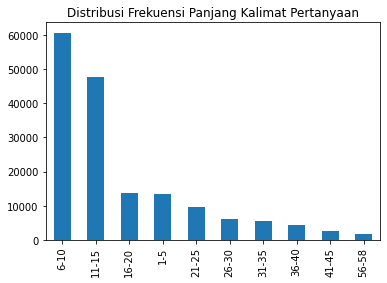

In [0]:
TAKEN_QUANTILE = 0.99 #param {type:"number"}

def pad_tensor(tensor, value, length):
    tensor.extend([value for _ in range(length - len(tensor))])

def get_sentence_and_question_max_length(taken_quantile):
    sentence_lengths = []
    for paragraph in df_squad['paragraphs']:
        for qas in paragraph:
            context_sentences = nltk.tokenize.sent_tokenize(qas['context'])
            for sentence in context_sentences:
                sentence_lengths.append(len(tokenize(normalize_string(sentence))))
    df_sentence_lengths = pd.DataFrame(sentence_lengths)
    sentence_lengths_desc = df_sentence_lengths.describe()
    print(sentence_lengths_desc, end='\n\n')

    question_lengths = []
    for paragraph in df_squad['paragraphs']:
        for qas in paragraph:
            for qa in qas['qas']:
                question_lengths.append(len(tokenize(qa['question'])))
    df_question_lengths = pd.DataFrame(question_lengths)
    question_lengths_desc = df_question_lengths.describe()
    print(question_lengths_desc, end='\n\n')

    print(df_sentence_lengths[0].apply(convert_value_to_range,
                                       args=(
                                           df_sentence_lengths[0].min(),
                                           df_sentence_lengths[0].max(), 5
                                           )
                                       ).value_counts().plot(kind='bar', title='Distribusi Frekuensi Panjang Kalimat Bacaan'))
    print(df_question_lengths[0].apply(convert_value_to_range,
                                       args=(
                                           df_question_lengths[0].min(),
                                           df_question_lengths[0].max(), 5
                                           )
                                       ).value_counts().plot(kind='bar', title='Distribusi Frekuensi Panjang Kalimat Pertanyaan'))

    sentence_quantile = df_sentence_lengths.quantile(taken_quantile)[0].astype(int)
    question_quantile = df_question_lengths.quantile(taken_quantile)[0].astype(int)
    return sentence_quantile, question_quantile

SENTENCE_MAX_LENGTH, QUESTION_MAX_LENGTH = get_sentence_and_question_max_length(TAKEN_QUANTILE)
QUESTION_MAX_LENGTH += 2    # include SOS and EOS
print(SENTENCE_MAX_LENGTH)
print(QUESTION_MAX_LENGTH)

In [0]:
# sentence_lengths = []
# sentences = []
# for paragraph in df_squad['paragraphs']:
#     for qas in paragraph:
#         context_sentences = nltk.tokenize.sent_tokenize(qas['context'])
#         for sentence in context_sentences:
#             sentence_lengths.append(len(tokenize(normalize_string(sentence))))
#             sentences.append(sentence)
# df_sentence_lengths = pd.DataFrame(sentence_lengths)
# sentence_lengths_desc = df_sentence_lengths.describe()
# print(sentence_lengths_desc, end='\n\n')

# idx = df_sentence_lengths[df_sentence_lengths[0]==SENTENCE_MAX_LENGTH]['sentence'].index.tolist()[0]
# sentences[idx]

### Answer Preprocessor

In [0]:
from fuzzywuzzy import fuzz

WORD_SIMILARITY_THRESHOLD = 80

def convert_charloc_to_wordloc(tokenized_context, tokenized_words, char_loc):
    if len(tokenized_words) == 0:
        return -2

    pointer_loc = 0
    i = 0
    j = 0
    while i < len(tokenized_context) and j < min(2, len(tokenized_words)):
        if char_loc-pointer_loc <= 5:
            if tokenized_context[i].isnumeric():
                similarity = fuzz.ratio(tokenized_context[i], tokenized_words[j])
            else:
                similarity = fuzz.partial_ratio(tokenized_context[i], tokenized_words[j])
            # print(f'{tokenized_context[i]} vs {tokenized_words[j]} = {similarity}')
            if similarity >= WORD_SIMILARITY_THRESHOLD:
                j += 1
        pointer_loc += len(tokenized_context[i]) + 1
        i += 1
    if j >= min(2, len(tokenized_words)):
        return i-j
    else:
        return -1

In [0]:
def is_end_punctuations(token):
    return token in '.!?'

def get_sentence_location_from_answer_word_index(tokenized_context, answer_word_idx):
    start_idx = answer_word_idx-1
    end_idx = answer_word_idx
    while start_idx > -1 and not is_end_punctuations(tokenized_context[start_idx]):
        start_idx -= 1
    while end_idx < len(tokenized_context)-1 and not is_end_punctuations(tokenized_context[end_idx]):
        end_idx += 1
    return start_idx+1, end_idx

context = 'Aku adalah. Anak gembala! Selalu riang.serta gembira? Karena aku raj!in bek?erja tak pernah lengah ataupun lelah.. Lalala'
tokenized_context = tokenize(normalize_string(context))
answer_idx = 0
start_idx, end_idx = get_sentence_location_from_answer_word_index(tokenized_context, answer_idx)
print(' '.join(tokenized_context[start_idx:end_idx+1]))

Aku adalah .


In [0]:
# for topic in df_squad.iloc[2]['paragraphs']:
#     print(topic['context'])

In [0]:
# context_idx = 0
# topic_idx = 0
# qa_idx = 2

# tokenized_context = tokenize(normalize_string(df_squad.iloc[context_idx]['paragraphs'][topic_idx]['context']))
# count_tobe_removed_chars = len(re.findall(non_ascii_regex, unicodeToAscii(df_squad.iloc[context_idx]['paragraphs'][topic_idx]['context']))) * 1.5
# print(count_tobe_removed_chars)
# qa = df_squad.iloc[context_idx]['paragraphs'][topic_idx]['qas'][qa_idx]
# indonesian_answer = qa.get('indonesian_answers') or qa.get('indonesian_plausible_answers')
# answer = indonesian_answer[0]
# tokenized_words = tokenize(normalize_string(answer['text']))
# print(df_squad.iloc[context_idx]['paragraphs'][topic_idx]['context'])
# print(answer['text'])
# print(tokenized_context)
# print(tokenized_words)
# print(qa)

# answer_idx = convert_charloc_to_wordloc(tokenized_context, tokenized_words, answer['answer_start'] - count_tobe_removed_chars)

# print(tokenized_context[answer_idx:answer_idx+len(tokenized_words)])
# print(tokenized_words)


# # def convert_word_to_word_embedding(tokenized_words, model, target_shape, conversion_purpose:str, taken_topic_idx=-1, taken_context_idx=-1, qas_idx=-1):
# #     tensor = []
# #     for i in range(len(tokenized_words)):
# #       try:
# #           word_embedding = model.wv[tokenized_words[i]]
# #       except KeyError as e:
# #           print(f'{conversion_purpose} exception {e} at topic_idx={taken_topic_idx}, taken_context_idx={taken_context_idx}, qas_idx={qas_idx}')
# #           word_embedding = model.wv[OOV_REPLACEMENT]
# #       finally:
# #           tensor.append(word_embedding)
# #     tensor = np.array(tensor)
# #     padded_tensor = np.zeros(target_shape)
# #     padded_tensor[:tensor.shape[0], :tensor.shape[1]] = tensor
# #     return padded_tensor

# #            input_pretrained_weight.append(np.concatenate((context_tensor, answer_tensor), axis=1))

### NER Preprocessor

In [0]:
def create_ner_tensor(tokenized_context, entities, ner_textdict):
    ner_tensor = [0 for _ in range(len(tokenized_context))]

    if len(entities) == 0:
        return ner_tensor

    pointer_loc = 0
    i = 0
    j = 0
    k = 0
    entities_name = tokenize(entities[j]['name'])
    while i < len(tokenized_context) and entities_name != None:
        pointer_loc += len(tokenized_context[i]) + 1
        if entities[j]['begin_offset']-pointer_loc <= 0:
            similarity = fuzz.partial_ratio(tokenized_context[i], entities_name[k])
            # print(f'{tokenized_context[i]} vs {entities_name[k]} = {similarity}')
            if similarity >= WORD_SIMILARITY_THRESHOLD:
                ner_tensor[i] = ner_textdict.word2index[entities[j]['type']]
                k += 1
                if k == len(entities_name):
                    j += 1
                    k = 0
                    entities_name = None if j == len(entities) else tokenize(entities[j]['name'])
            i += 1
    
    return ner_tensor

taken_topic_idx = 1
taken_content_idx = 0
context = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_content_idx].get('context')
print(context)
entities = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_content_idx].get('entities')
print(entities)
ner_tensor = create_ner_tensor(tokenize(normalize_string(context)), entities, ner_textdict)
print(ner_tensor)
print([ner_textdict.index2word[ne] for ne in ner_tensor])
print(tokenize(normalize_string(context)))

Frédéric François Chopin (/ ˈʃoʊpæn /; pengucapan Prancis: [fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃]; 22 Februari atau 1 Maret 1810 - 17 Oktober 1849), kelahiran Fryderyk Franciszek Chopin, [bukan 1] adalah bahasa Polandia dan komposer Prancis (berdasarkan kewarganegaraan dan kelahiran ayah) dan seorang pianis virtuoso dari era Romantis, yang menulis terutama untuk piano solo. Dia memperoleh dan telah mempertahankan terkenal di seluruh dunia sebagai salah satu musisi terkemuka di zamannya, yang "jenius puitisnya didasarkan pada teknik profesional yang tak ada bandingannya dalam generasinya." Chopin lahir di wilayah yang pada waktu itu adalah Kadipaten Warsawa, dan tumbuh di Warsawa, yang setelah 1815 menjadi bagian dari Kongres Polandia. Sebagai anak ajaib, ia menyelesaikan pendidikan musiknya dan menyusun karya-karyanya sebelumnya di Warsawa sebelum meninggalkan Polandia pada usia 20 tahun, kurang dari sebulan sebelum pecahnya Pemberontakan November 1830.
[{'begin_offset': 0, 'length': 17, 'name':

### PosTags Preprocessor

In [0]:
FULL_MATCH = 100

def flatten(list):
    new_list = []
    for list_ in list:
        new_list.extend(list_)
    return new_list

def calc_n_gram_similarity(n, token_1, postags, j):
    n_gram = ''
    if j+n < len(postags):
        for k in range(n):
            n_gram += postags[j+k][0]
        # print(f'{n}-gram: {token_1} vs {n_gram} = {fuzz.ratio(token_1, n_gram)}')
        return fuzz.ratio(token_1, n_gram)
    else:
        return 0

MAX_N_GRAM = 5
def create_postags_tensor(tokenized_context, postags_, postags_textdict):
    pos_tensor = [0 for _ in range(len(tokenized_context))]

    if len(postags_) == 0:
        return pos_tensor

    average_sim = []
    j = 0
    postags = flatten(postags_)
    for i in range(len(tokenized_context)):
        n = 1
        found = False
        iter_limit = MAX_N_GRAM - max(0, i + 5 - len(tokenized_context))
        prev_n_gram_similarity = 0
        while n <= iter_limit and not found:
            n_gram_similarity = calc_n_gram_similarity(n, tokenized_context[i], postags, j)
            if n_gram_similarity == 0:
                pos_tensor[i] = NONE_NER_POS_TOKEN
                found = True
            elif n_gram_similarity != FULL_MATCH and n < iter_limit:
                if n_gram_similarity > prev_n_gram_similarity:
                    prev_n_gram_similarity = n_gram_similarity
                elif n_gram_similarity <= prev_n_gram_similarity:
                    j -= 1
                    pos_tensor[i] = postags_textdict.word2index[postags[j-n+1][1]]
                    # print(f'\t{tokenized_context[i]} {postags[j-n+1][1]}')
                    j += n
                    found = True
            elif n_gram_similarity >= WORD_SIMILARITY_THRESHOLD:
                pos_tensor[i] = postags_textdict.word2index[postags[j-n+1][1]]
                # print(f'\t{tokenized_context[i]} {postags[j-n+1][1]}')
                j += n
                found = True
            else:
                pos_tensor[i] = NONE_NER_POS_TOKEN
                found = True
            n += 1
        average_sim.append(n_gram_similarity if n_gram_similarity > prev_n_gram_similarity else prev_n_gram_similarity)
    # average_sim = sum(average_sim)/len(average_sim)
    # print(f'Average similarity: {average_sim:.2f}%')
    return pos_tensor

taken_topic_idx = 1
taken_content_idx = 0
context = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_content_idx].get('context')
print(context)
postags = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_content_idx].get('postags')
print(postags)
postags_tensor = create_postags_tensor(tokenize(normalize_string(context)), postags, postags_textdict)
print(postags_tensor)
print([postags_textdict.index2word[postag] for postag in postags_tensor])
print(tokenize(normalize_string(context)))

Frédéric François Chopin (/ ˈʃoʊpæn /; pengucapan Prancis: [fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃]; 22 Februari atau 1 Maret 1810 - 17 Oktober 1849), kelahiran Fryderyk Franciszek Chopin, [bukan 1] adalah bahasa Polandia dan komposer Prancis (berdasarkan kewarganegaraan dan kelahiran ayah) dan seorang pianis virtuoso dari era Romantis, yang menulis terutama untuk piano solo. Dia memperoleh dan telah mempertahankan terkenal di seluruh dunia sebagai salah satu musisi terkemuka di zamannya, yang "jenius puitisnya didasarkan pada teknik profesional yang tak ada bandingannya dalam generasinya." Chopin lahir di wilayah yang pada waktu itu adalah Kadipaten Warsawa, dan tumbuh di Warsawa, yang setelah 1815 menjadi bagian dari Kongres Polandia. Sebagai anak ajaib, ia menyelesaikan pendidikan musiknya dan menyusun karya-karyanya sebelumnya di Warsawa sebelum meninggalkan Polandia pada usia 20 tahun, kurang dari sebulan sebelum pecahnya Pemberontakan November 1830.
[[['Frederic', 'NNP'], ['Francois', 'NNP']

In [0]:
# results = []
# for taken_topic_idx in range(df_squad.shape[0]):
#     for taken_content_idx in range(len(df_squad.iloc[taken_topic_idx]['paragraphs'])):
#         context = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_content_idx].get('context')
#         # print(context)
#         postags = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_content_idx].get('postags')
#         # print(postags)
#         # print(create_postags_tensor(tokenize(normalize_string(context)), postags, postags_textdict))
#         _, result = create_postags_tensor(tokenize(normalize_string(context)), postags, postags_textdict)
#         results.append(result)
#         if result < 95:
#             print(f'{taken_topic_idx}, {taken_content_idx}, {result}')

### Do Preprocess

In [0]:
def do_preprocess(df_squad, text_dict, reject_non_ne:bool) -> (any, list, list, list):
    input_tensors = []
    is_answer_tensors = []
    is_cased_tensors = []
    ner_tensors = []
    pos_tensors = []

    target_tensors = []

    deleted = 0

    start_time = time.time()
    for taken_topic_idx in range(df_squad.shape[0]):
        for taken_context_idx in range(len(df_squad.iloc[taken_topic_idx]['paragraphs'])):
            context = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_context_idx]['context']
            tokenized_context = tokenize(normalize_string(context))
            count_tobe_removed_chars = len(re.findall(non_ascii_regex, unicode_to_ascii(context))) * 1.5  # With assumption every nonascii is followed by space

            try:
                entities = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_context_idx]['entities']
                postags = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_context_idx]['postags']
            except KeyError:
                print(f'Key Error, skipped ({taken_topic_idx}, {taken_content_idx})')
                i += 1
                continue
            entities = create_ner_tensor(tokenized_context, entities, ner_textdict)
            postags = create_postags_tensor(tokenized_context, postags, postags_textdict)

            qas = df_squad.iloc[taken_topic_idx]['paragraphs'][taken_context_idx]['qas']
            i = 0
            while i < len(qas):
                qa = qas[i]

                indonesian_answer = qa.get('indonesian_answers') or qa.get('indonesian_plausible_answers')
                # indonesian_answer = qa.get('indonesian_answers')
                # if indonesian_answer is None:
                #     print(f'Found impossible question, Skipped..')
                #     i += 1
                #     continue
                tokenized_answers = tokenize(normalize_string(indonesian_answer[0]['text']))
                answer_start = indonesian_answer[0]['answer_start'] - count_tobe_removed_chars
                answer_idx = convert_charloc_to_wordloc(tokenized_context, tokenized_answers, answer_start)
                if answer_idx < 0:
                    print(f'Not found at topic_idx={taken_topic_idx}, taken_context_idx={taken_context_idx}, qas_idx={i}')
                    deleted += 1
                    qas.pop(i)
                    continue

                sent_start_idx, sent_end_idx = get_sentence_location_from_answer_word_index(tokenized_context, answer_idx)
                tokenized_sentence = tokenized_context[sent_start_idx:sent_end_idx+1]
                answer_idx -= sent_start_idx
                sentence_tensor = [
                    text_dict.word2index.get(word) if text_dict.word2index.get(word) \
                    else OOV \
                    for word in tokenized_sentence
                ]
                if sent_end_idx-sent_start_idx+1 > SENTENCE_MAX_LENGTH:
                    # print(f'Sentence too long, skipped ({taken_topic_idx}, {taken_content_idx})')
                    i += 1
                    continue

                ner_tensor = [entities[i] for i in range(sent_start_idx, sent_end_idx+1)]
                pos_tensor = [postags[i] for i in range(sent_start_idx, sent_end_idx+1)]
                pad_tensor(sentence_tensor, PAD, SENTENCE_MAX_LENGTH)
                pad_tensor(ner_tensor, NONE_NER_POS_TOKEN, SENTENCE_MAX_LENGTH)
                pad_tensor(pos_tensor, NONE_NER_POS_TOKEN, SENTENCE_MAX_LENGTH)

                answer_idx_range = (answer_idx, answer_idx+len(tokenized_answers))
                # non_ne rejection
                if reject_non_ne and (torch.tensor(ner_tensor[answer_idx:answer_idx+len(tokenized_answers)])==NONE_NER_POS_TOKEN).all():
                    # print(f'Answer is not a named entity, skipped ({taken_topic_idx}, {taken_content_idx})')
                    i += 1
                    continue

                is_answer_tensor = []
                is_cased_tensor = []
                for j in range(SENTENCE_MAX_LENGTH):
                    is_answer_tensor.append(
                        1 if j in range(answer_idx, answer_idx+len(tokenized_answers)) \
                        else 0
                    )
                    is_cased_tensor.append(
                        1 if j<len(tokenized_sentence) and any(c.isupper() for c in tokenized_sentence[j]) \
                        else 0
                    )

                indonesian_question = qa['question']
                tokenized_questions = tokenize(normalize_string(indonesian_question))
                if len(tokenized_questions) > QUESTION_MAX_LENGTH-2:
                    # print(f'Question too long, skipped ({taken_topic_idx}, {taken_content_idx})')
                    i += 1
                    continue
                # if tokenized_questions[0].lower() != "kapan":
                #     print(f'Only accept "kapan" question. Skipping..')
                #     i += 1
                #     continue

                question_tensor = [
                    text_dict.word2index.get(word) if text_dict.word2index.get(word) \
                    else OOV \
                    for word in tokenized_questions
                ]
                question_tensor.insert(0, SOS)
                question_tensor.append(EOS)
                pad_tensor(question_tensor, PAD, QUESTION_MAX_LENGTH)

                input_tensors.append(sentence_tensor)
                is_answer_tensors.append(is_answer_tensor)
                is_cased_tensors.append(is_cased_tensor)
                ner_tensors.append(ner_tensor)
                pos_tensors.append(pos_tensor)
                target_tensors.append(question_tensor)

                i += 1
    end_time = time.time()

    input_tensors = np.array(input_tensors).reshape((len(input_tensors), -1, 1))
    is_answer_tensors = np.array(is_answer_tensors).reshape((len(is_answer_tensors), -1, 1))
    is_cased_tensors = np.array(is_cased_tensors).reshape((len(is_cased_tensors), -1, 1))
    ner_tensors = np.array(ner_tensors).reshape((len(ner_tensors), -1, 1))
    pos_tensors = np.array(pos_tensors).reshape((len(pos_tensors), -1, 1))
    feature_tensors = np.concatenate((is_answer_tensors, is_cased_tensors, ner_tensors, pos_tensors), axis=-1)
    target_tensors = np.array(target_tensors).reshape((len(target_tensors), -1, 1))

    print(f'Not found answers: {deleted}')
    print(f'Execution time: {end_time-start_time}')
    return df_squad, input_tensors, feature_tensors, target_tensors

## Action!

In [0]:
MAX_VOCABULARY = 60000
populate_text_dict(text_dict, df_squad, MAX_VOCABULARY)

Original vocabulary: 97466
Least frequent words will be removed until n_vocab = 60000
Execution time: 10.351666688919067


In [0]:
print(text_dict.n_words)
print(list(enumerate(text_dict.word2count.items()))[55815])

60000
(55815, ('Buddhacarita', 1))


In [0]:
REJECT_NON_NE = False

In [0]:
df_squad, input_tensors, feature_tensors, target_tensors = do_preprocess(df_squad, text_dict, REJECT_NON_NE)

Not found at topic_idx=6, taken_context_idx=0, qas_idx=5
Not found at topic_idx=13, taken_context_idx=54, qas_idx=1
Not found at topic_idx=17, taken_context_idx=27, qas_idx=0
Not found at topic_idx=17, taken_context_idx=27, qas_idx=5
Not found at topic_idx=21, taken_context_idx=6, qas_idx=1
Not found at topic_idx=21, taken_context_idx=6, qas_idx=3
Not found at topic_idx=24, taken_context_idx=38, qas_idx=2
Not found at topic_idx=24, taken_context_idx=39, qas_idx=6
Not found at topic_idx=34, taken_context_idx=24, qas_idx=3
Not found at topic_idx=39, taken_context_idx=38, qas_idx=1
Not found at topic_idx=40, taken_context_idx=1, qas_idx=1
Not found at topic_idx=41, taken_context_idx=10, qas_idx=2
Not found at topic_idx=41, taken_context_idx=10, qas_idx=3
Not found at topic_idx=41, taken_context_idx=10, qas_idx=4
Not found at topic_idx=46, taken_context_idx=4, qas_idx=0
Not found at topic_idx=46, taken_context_idx=4, qas_idx=3
Not found at topic_idx=53, taken_context_idx=19, qas_idx=1
Not 

In [0]:
df_squad_test, input_test_tensors, feature_test_tensors, target_test_tensors = do_preprocess(df_squad_test, text_dict, REJECT_NON_NE)

Not found at topic_idx=8, taken_context_idx=15, qas_idx=4
Not found at topic_idx=12, taken_context_idx=19, qas_idx=5
Not found at topic_idx=29, taken_context_idx=11, qas_idx=1
Not found at topic_idx=29, taken_context_idx=26, qas_idx=1
Not found at topic_idx=31, taken_context_idx=25, qas_idx=0
Not found at topic_idx=31, taken_context_idx=25, qas_idx=4
Not found at topic_idx=32, taken_context_idx=8, qas_idx=1
Not found answers: 7
Execution time: 3.7326998710632324


In [0]:
print(input_tensors.shape)
print(feature_tensors.shape)
print(input_test_tensors.shape)
print(feature_test_tensors.shape)

(116421, 66, 1)
(116421, 66, 4)
(10536, 66, 1)
(10536, 66, 4)


In [0]:
# def print_input_and_answer(input_tensors, is_answer_tensors, text_dict, n=3):
#     i = 0
#     while i < len(input_tensors) and i < n:
#         sentence_tensor = input_tensors[i].squeeze()
#         is_answer_tensor = is_answer_tensors[i].squeeze()
#         print(is_answer_tensor)
#         sentence = ' '.join([text_dict.index2word[word_idx] for word_idx in sentence_tensor])
#         answer = ' '.join([text_dict.index2word[sentence_tensor[idx]] if is_answer_tensor[idx]==1 else '' for idx in range(is_answer_tensor.size)]).strip()
#         print(sentence)
#         print(f'Answer: {answer}')
#         i += 1

def print_input_and_answer(input_tensors, feature_tensors, target_tensors, text_dict, n=3, randomized=True):
    for j in range(n):
        i = j if not randomized else random.randint(0, len(input_tensors))
        print('Idx:', i)
        input_tensor = input_tensors[i]
        feature_tensor = feature_tensors[i]
        target_tensor = target_tensors[i]
        is_answer_tensor = feature_tensor[:,0]
        input_text = ' '.join([text_dict.index2word[word_idx.item()] for word_idx in input_tensor])
        target_text = ' '.join([text_dict.index2word[word_idx.item()] for word_idx in target_tensor])
        answer_text = ' '.join([text_dict.index2word[input_tensor[idx].item()] if is_answer_tensor[idx]==1 else '' for idx in range(len(is_answer_tensor))]).strip()
        print('>', input_text)
        print('=', target_text)
        print('-', answer_text)
        print('')

In [0]:
print('TRAIN DATASET:')
print_input_and_answer(input_tensors, feature_tensors, target_tensors, text_dict)
print()

print('TEST DATASET :')
print_input_and_answer(input_test_tensors, feature_test_tensors, target_test_tensors, text_dict)

TRAIN DATASET:
Idx: 83810
> Industri PV telah melihat penurunan harga modul sejak 2008 . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
= <sos> Industri PV telah mengalami penurunan harga modul sejak tahun berapa ? <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
- 2008

Idx: 14592
> Basis pengguna Chrome terus tumbuh dan pada Mei 2012 , penggunaan Chrome melewati penggunaan semua versi Internet Explorer digabungkan . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
= 

In [0]:
def shuffle(*args):
    indices = np.arange(args[0].shape[0])
    np.random.shuffle(indices)
    result = []
    for i in range(len(args)):
        result.append(args[i][indices])
    return tuple(result)

def convert_to_torch(*args):
    result = []
    for i in range(len(args)):
        result.append(torch.tensor(args[i]).long().to(device))
    return tuple(result)

def split_by_k(*args, k=0.9):
    assert 0 < k < 1, 'k must be between 0 and 1!'
    group_1 = []
    group_2 = []
    split_idx = int(k * len(args[0]))
    for i in range(len(args)):
        group_1.append(args[i][:split_idx])
        group_2.append(args[i][split_idx:])
    group_1.extend(group_2)
    return tuple(group_1)

In [0]:
input_tensors, feature_tensors, target_tensors = shuffle(input_tensors, feature_tensors, target_tensors)
input_tensors, feature_tensors, target_tensors, input_val_tensors, feature_val_tensors, target_val_tensors = split_by_k(input_tensors, feature_tensors, target_tensors, k=0.8)

print('Preparing train tensors')
input_tensors, feature_tensors, target_tensors = convert_to_torch(input_tensors, feature_tensors, target_tensors)
print('Input size:', input_tensors.size())
print('Features size:', feature_tensors.size())
print('Target size:', target_tensors.size())
print()

print('Preparing val tensors')
input_val_tensors, feature_val_tensors, target_val_tensors = convert_to_torch(input_val_tensors, feature_val_tensors, target_val_tensors)
print('Input size:', input_val_tensors.size())
print('Features size:', feature_val_tensors.size())
print('Target size:', target_val_tensors.size())
print()

print('Preparing test tensors')
input_test_tensors, feature_test_tensors, target_test_tensors = convert_to_torch(input_test_tensors, feature_test_tensors, target_test_tensors)
print('Input size:', input_test_tensors.size())
print('Features size:', feature_test_tensors.size())
print('Target size:', target_test_tensors.size())

Preparing train tensors
Input size: torch.Size([93136, 66, 1])
Features size: torch.Size([93136, 66, 4])
Target size: torch.Size([93136, 22, 1])

Preparing val tensors
Input size: torch.Size([23285, 66, 1])
Features size: torch.Size([23285, 66, 4])
Target size: torch.Size([23285, 22, 1])

Preparing test tensors
Input size: torch.Size([10536, 66, 1])
Features size: torch.Size([10536, 66, 4])
Target size: torch.Size([10536, 22, 1])


In [0]:
# Count rows which contain non-zero element
print('Train:', np.unique(feature_tensors.cpu().numpy().nonzero()[0]).shape[0])
print('Val:', np.unique(feature_val_tensors.cpu().numpy().nonzero()[0]).shape[0])
print('Test:', np.unique(feature_test_tensors.cpu().numpy().nonzero()[0]).shape[0])

Train: 93136
Val: 23285
Test: 10536


## Create Weights Matrix Embedding using FastText

In [0]:
pretrained_weight = np.zeros((len(text_dict.index2word), EMBEDDING_SIZE))

def convert_word_to_word_embedding(word, model):
    try:
        word_embedding = model.wv[word]
    except KeyError as e:
        print(f'{type(e).__name__} exception: {e}.')
        word_embedding = model.wv[OOV_TOKEN]
    return word_embedding

for i, word in text_dict.index2word.items():
    pretrained_weight[i] = convert_word_to_word_embedding(word, model)
print(f'All unknown words will be replaced with {OOV_TOKEN}')

pretrained_weight = torch.from_numpy(pretrained_weight).float()
print(f'Weights matrix size: {pretrained_weight.size()}')
print(f'Total unique words count: {text_dict.n_words}')

KeyError exception: 'all ngrams for word Zywny absent from model'.
KeyError exception: 'all ngrams for word 14:28 absent from model'.
KeyError exception: 'all ngrams for word Cwn absent from model'.
KeyError exception: 'all ngrams for word fmr absent from model'.
KeyError exception: 'all ngrams for word Prme absent from model'.
KeyError exception: 'all ngrams for word VFH absent from model'.
KeyError exception: 'all ngrams for word 3:10 absent from model'.
KeyError exception: 'all ngrams for word nSr absent from model'.
KeyError exception: 'all ngrams for word ` absent from model'.
KeyError exception: 'all ngrams for word EF0 absent from model'.
KeyError exception: 'all ngrams for word gqh absent from model'.
KeyError exception: 'all ngrams for word 9O absent from model'.
KeyError exception: 'all ngrams for word GJU absent from model'.
KeyError exception: 'all ngrams for word L2C absent from model'.
KeyError exception: 'all ngrams for word WHRB absent from model'.
KeyError exception: '

In [0]:
pretrained_weight.dtype

torch.float32

In [0]:
import gc
gc.collect()

383

# Sequence to Sequence

## Helper Function

In [0]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m:d}m {s:2.3f}s'


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'{asMinutes(s)} (- {asMinutes(rs)})'
    

def count_n_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
def get_batch(train_data, feature_data, target_data, batch_size, i):
    i_end = min(i+batch_size, train_data.size(0)+1)
    return train_data[i:i_end], feature_data[i:i_end], target_data[i:i_end]

### Embedding Layer

In [0]:
# def create_emb_layer(pretrained_weight, non_trainable=False):
#     vocab_size, embedding_dim = pretrained_weight.size()
#     emb_layer = nn.Embedding(vocab_size, embedding_dim)
#     emb_layer.load_state_dict({'weight': pretrained_weight})
#     if non_trainable:
#         emb_layer.weight.requires_grad = False

#     return emb_layer, vocab_size, embedding_dim

### Plotting Results

[0.0002     0.0004     0.0006     0.0008     0.001      0.00094639
 0.00090309 0.00086719 0.00083683 0.00081071 0.00078795 0.00076787
 0.00075    0.00073395 0.00071944 0.00070623 0.00069413 0.00068301
 0.00067273 0.00066319 0.00065431 0.00064601 0.00063824 0.00063093
 0.00062404 0.00061754 0.00061139 0.00060555 0.0006     0.00059472
 0.00058968 0.00058488 0.00058028 0.00057588 0.00057165 0.0005676
 0.00056371 0.00055996 0.00055635 0.00055287 0.00054951 0.00054626
 0.00054313 0.00054009 0.00053716 0.00053431]


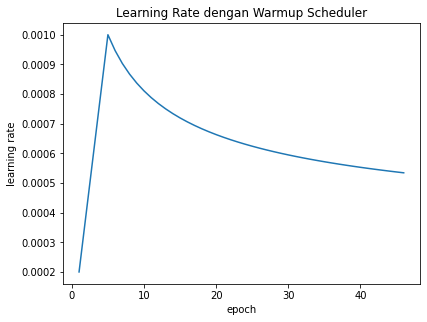

In [11]:
import math
import matplotlib.pyplot as plt
import numpy as np

a = [x+1 for x in range(5)]
fn = lambda x: 15 / math.log(x, 2)
b = [x for x in range(8, 50)]
c = a.copy()
c.extend(list(map(fn, b))[1:])
c = np.array(c) / 5000
print(c)

fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.set_title('Learning Rate dengan Warmup Scheduler')
ax.set_xlabel('epoch')
ax.set_ylabel('learning rate')
ax.plot([x for x in range(1, len(c)+1)], c)

In [0]:
plt.switch_backend('agg')
import matplotlib.ticker as ticker


def showPlot(points_1, points_2=[], title='Training Loss', label_1='loss', label_2='val_loss', save=False, path='./figures.jpg'):
    fig, ax = plt.subplots(figsize=(6.4, 4.8))
    ax.set_title(title)

    range_1 = max(points_1) - min(points_1)
    range_2 = 0 if not points_2 else max(points_2) - min(points_2)
    global_range = range_1 + range_2
    base = round(global_range*0.06, 1) or round(global_range*0.06, 2)
    if base > 0:
        loc = ticker.MultipleLocator(base=base)
        ax.yaxis.set_major_locator(loc)

    ax.plot(points_1, label=label_1)
    ax.plot(points_2, label=label_2)
    ax.legend()

    if save:
        fig.savefig(path)
    else:
        fig.show()

### Evaluation

In [0]:
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# # from nltk.translate.meteor_score import exact_match

# def calculate_eval_score(target, prediction):
#     cc = SmoothingFunction()
#     try:
#         bleu_1 = sentence_bleu(target, prediction, smoothing_function=None, weights=(1, 0, 0, 0))
#         bleu_2 = sentence_bleu(target, prediction, smoothing_function=None, weights=(0, 1, 0, 0))
#         bleu_3 = sentence_bleu(target, prediction, smoothing_function=None, weights=(0, 0, 1, 0))
#         bleu_4 = sentence_bleu(target, prediction, smoothing_function=None, weights=(0, 0, 0, 1))
#     except:
#         return [None, None, None, None]
#     # meteor = exact_match(' '.join(target[0]), ' '.join(prediction))
#     return [bleu_1, bleu_2, bleu_3, bleu_4]

# from torchtext.data.metrics import bleu_score

# def calculate_eval_score_torchtext(target, prediction):
#     print(target)
#     print(prediction)
#     bleu_1 = bleu_score(prediction, target, max_n=1, weights=[1])
#     bleu_2 = bleu_score(prediction, target, max_n=2, weights=[0, 1])
#     bleu_3 = bleu_score(prediction, target, max_n=3, weights=[0, 0, 1])
#     bleu_4 = bleu_score(prediction, target, max_n=4, weights=[0, 0, 0, 1])
#     bleu_all = bleu_score(prediction, target, max_n=4)
#     bleu_avg = (bleu_1 + bleu_2 + bleu_3 + bleu_4)/4
#     return [bleu_1, bleu_2, bleu_3, bleu_4, bleu_all, bleu_avg]

nlgeval = NLGEval(metrics_to_omit=['CIDEr', 'EmbeddingAverageCosineSimilairty', 'EmbeddingAverageCosineSimilarity', 'GreedyMatchingScore', 'SkipThoughtCS', 'VectorExtremaCosineSimilarity'])  # loads the models
def calculate_eval_score(nlgeval, references, hypothesis, ndigits=4):
    result_dict = nlgeval.compute_individual_metrics(references, hypothesis)
    for key, val in result_dict.items():
        result_dict[key] = round(val, ndigits)
    result_dict['Bleu_avg'] = (result_dict['Bleu_1'] + result_dict['Bleu_2'] + result_dict['Bleu_3'] + result_dict['Bleu_4'])/4
    return result_dict

def clean_and_merge(word_list):
    result = []
    i = 0
    while i < len(word_list) and word_list[i] != EOS_TOKEN:
        result.append(word_list[i])
        i += 1
    return ' '.join(result)

def dict_mean(dict_list):
    mean_dict = {}
    for key in dict_list[0].keys():
        mean_dict[key] = round(sum(d[key] for d in dict_list) / len(dict_list), 4)
    return mean_dict

In [0]:
calculate_eval_score(nlgeval,
                     ['aku adalah anak gembala wo is picik herder'],
                     'beta shi childof peternak aku adalah anak gembala')
# calculate_eval_score_torchtext(
#                      [['aku adalah anak gembala wo is picik herder'.split()]],
#                      ['beta shi childof peternak aku adalah anak gembala'.split()])

{'Bleu_1': 0.5,
 'Bleu_2': 0.4629,
 'Bleu_3': 0.4149,
 'Bleu_4': 0.3457,
 'Bleu_avg': 0.430875,
 'METEOR': 0.2934,
 'ROUGE_L': 0.5}

## Vanilla GRU/LSTM

### Model

In [0]:
class Encoder(nn.Module):
    def __init__(self, pretrained_weight, feature_tensors, enc_hid_dim, dec_hid_dim, num_layers, dropout, rnn_type='gru'):
        super().__init__()
        print('Encoder type:', rnn_type)
        self.rnn_type = rnn_type
        
        vocab_size, emb_dim = pretrained_weight.size()
        self.embedding = nn.Embedding.from_pretrained(pretrained_weight, freeze=False)
        intermediate_dim = emb_dim + feature_tensors.size(-1)

        if rnn_type == 'gru':
            self.rnn = nn.GRU(intermediate_dim, enc_hid_dim, num_layers=num_layers, dropout=dropout, bidirectional = True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(intermediate_dim, enc_hid_dim, num_layers=num_layers, dropout=dropout, bidirectional = True)
        else:
            raise ValueError('Encoder type must be gru or lstm!')
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        # self.dropout = nn.Dropout(0.3)
        
    def _merge_bi_states(self, hidden):
        if self.rnn_type == 'gru':
            hidden_result = []
            for i in range(1, self.rnn.num_layers + 1):
                hidden_result.append(torch.tanh(self.fc(torch.cat((hidden[-2*i, :, :], hidden[-1*i, :, :]), dim = 1))).unsqueeze(0))
            hidden_result = torch.cat(hidden_result, dim=0)
        else:
            hidden_h = []
            hidden_c = []
            for i in range(1, self.rnn.num_layers + 1):
                hidden_h.append(torch.tanh(self.fc(torch.cat((hidden[0][-2*i,:,:], hidden[0][-1*i,:,:]), dim = 1))).unsqueeze(0))
                hidden_c.append(torch.tanh(self.fc(torch.cat((hidden[1][-2*i,:,:], hidden[1][-1*i,:,:]), dim = 1))).unsqueeze(0))
            hidden_result = (torch.cat(hidden_h, dim=0), torch.cat(hidden_c, dim=0))
        return hidden_result

    def forward(self, src, src_lengths, features):
        #src = [src len, batch size]
        #src_lengths = [batch size]
        
        # embedded = self.dropout(self.embedding(src.squeeze(-1)))
        embedded = self.embedding(src.squeeze(-1))
        #embedded = [src len, batch size, emb dim]

        concated = torch.cat((embedded, features.float()), -1)
                
        packed_embedded = nn.utils.rnn.pack_padded_sequence(concated, src_lengths, enforce_sorted=False)
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, total_length=src.size(0))

        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #if gru,  hidden = [n layers * num directions, batch size, hid dim]
        #if lstm, hidden = tuple(hidden, hidden)
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = self._merge_bi_states(hidden)
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [n layers, batch size, dec hid dim]
        
        return outputs, hidden

In [0]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [0]:
class Decoder(nn.Module):
    def __init__(self, pretrained_weight, enc_hid_dim, dec_hid_dim, attention, num_layers, dropout, rnn_type='gru'):
        super().__init__()
        print('Decoder type:', rnn_type)
        self.rnn_type = rnn_type
        self.attention = attention
        
        vocab_size, emb_dim = pretrained_weight.size()
        self.output_dim = vocab_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_weight, freeze=False)
        
        if rnn_type == 'gru':
            self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim, num_layers=num_layers, dropout=dropout)    
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM((enc_hid_dim * 2) + emb_dim, dec_hid_dim, num_layers=num_layers, dropout=dropout)
        else:
            raise ValueError('Decoder type must be gru or lstm!')

        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, self.output_dim)        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        #input = [batch size]
        #if gru,  hidden = [n layers, batch size, dec hid dim]
        #if lstm, hidden = tuple(hidden, hidden)
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        if len(input.size()) > 2:
            input = input.squeeze(-1)
        
        #input = [1, batch size]
        
        # embedded = self.dropout(self.embedding(input))
        embedded = self.embedding(input)
        
        #embedded = [1, batch size, emb dim]
        
        if self.rnn_type == 'gru':
            a = self.attention(hidden[0], encoder_outputs, mask)  # only pass the hidden of the first layer
        elif self.rnn_type == 'lstm':
            a = self.attention(hidden[0][0], encoder_outputs, mask)  # only pass the hidden_h of the first layer
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden)
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]

        #seq len, n layers and n directions will always be 1 in this decoder if we only take the hiddens from last states from the last layer, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        num_direction = 2 if self.rnn.bidirectional else 1
        if self.rnn_type == 'gru':
            assert (output[0] == hidden[-1]).all()
        elif self.rnn_type == 'lstm':
            assert (output[0] == hidden[0][-1]).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, a.squeeze(1)

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        assert self.encoder.rnn.num_layers == self.decoder.rnn.num_layers, \
                f'Num_layers of encoder and decoder must be the same, get {self.encoder.num_layers} and {self.decoder.num_layers}.'
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).squeeze(-1).permute(1, 0)
        return mask
        
    def forward(self, src, src_lengths, features, trg, teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #src_lengths = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_lengths, features)

        #first input to the decoder is the <sos> tokens
        decoder_input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(decoder_input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            decoder_input = trg[t] if teacher_force else top1
            
        return outputs

### Train

In [0]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [0]:
N_PRINT_IN_EPOCH = 20

def train(model, criterion, optimizer, train_data, feature_data, target_data, batch_size, curr_epoch, clip=5):
    model.train()
    epoch_loss = 0
    print_total_loss = 0

    n_data = train_data.size(0)
    n_batch = math.ceil(n_data / batch_size)
    log_interval = max(1, n_batch // N_PRINT_IN_EPOCH)
    start_time = time.time()
    for batch, i in enumerate(range(0, n_data, batch_size), 1):
        data, features, targets = get_batch(train_data, feature_data, target_data, batch_size, i)
        src_lengths = torch.sum(data != PAD, dim=1).view(-1)
        src = data.permute(1, 0, 2)
        features = features.permute(1, 0, 2)
        trg = targets.permute(1, 0, 2)

        optimizer.zero_grad()
        
        output = model(src, src_lengths, features, trg, 1)      
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].reshape(-1)
        #output = [(trg len - 1) * batch size, output dim]
        #trg = [(trg len - 1) * batch size]
        
        loss = criterion(output, trg)        
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)        
        optimizer.step()        
        epoch_loss += loss.item()
        print_total_loss += loss.item()

        if batch % log_interval == 0:
            cur_loss = print_total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    curr_epoch, batch, n_batch, optimizer.param_groups[0]['lr'],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            print_total_loss = 0
            start_time = time.time()

    return epoch_loss / n_batch


def validate(model, criterion, val_data, val_feature_data, val_target_data, batch_size):    
    model.eval()    
    epoch_loss = 0
    n_data = val_data.size(0)
    n_batch = math.ceil(n_data / batch_size)
    with torch.no_grad():
        for batch, i in enumerate(range(0, n_data, batch_size)):
            data, features, targets = get_batch(val_data, val_feature_data, val_target_data, batch_size, i)
            src_lengths = torch.sum(data != PAD, dim=1).view(-1)
            src = data.permute(1, 0, 2)
            features = features.permute(1, 0, 2)
            trg = targets.permute(1, 0, 2)

            output = model(src, src_lengths, features, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].reshape(-1)
            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            epoch_loss += loss.item()        
    return epoch_loss / n_batch

In [0]:
SAVE_FREQUENCY = 3

def trainIters(model, input_tensors, feature_tensors, target_tensors, input_val_tensors, feature_val_tensors, target_val_tensors, clip, batch_size, epochs, learning_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.95, checkpoint=None):
    # best_val_loss = float("inf")
    # best_model = None
    start_epoch = 1
    plot_losses = []
    val_plot_losses = []

    criterion = nn.CrossEntropyLoss(ignore_index=PAD)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, scheduler_step_size, scheduler_gamma)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=learning_rate/100)

    if checkpoint is not None:
        start_epoch = checkpoint['next_epoch']
        plot_losses = checkpoint['plot_losses']
        val_plot_losses = checkpoint['val_plot_losses']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # optimizer.param_groups[0]['lr'] = learning_rate
        scheduler.load_state_dict(checkpoint['scheduler'])

    for epoch in range(start_epoch, epochs+1):    
        epoch_start_time = time.time()
        
        train_loss = train(model, criterion, optimizer,
                          input_tensors, feature_tensors, target_tensors,
                          BATCH_SIZE, epoch, clip)
        val_loss = validate(model, criterion,
                            input_val_tensors, feature_val_tensors, target_val_tensors,
                            BATCH_SIZE)
        plot_losses.append(train_loss)
        val_plot_losses.append(val_loss)
        
        scheduler.step()
        
        print('-' * 98)
        print('| end of epoch {:3d} | time: {:5.2f}s | avg loss {:5.2f} | valid loss {:5.2f} | '
              'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time), train_loss, val_loss, math.exp(val_loss)))
        print('-' * 98)

        if epoch == epochs or (SAVE_FREQUENCY != -1 and epoch % SAVE_FREQUENCY == 0):
            print('Saving model..')
            torch.save({
                'next_epoch': epoch + 1,
                'plot_losses': plot_losses,
                'val_plot_losses': val_plot_losses,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
            }, SAVE_PATH)

        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     torch.save(model.state_dict(), 'tut3-model.pt')
    return plot_losses, val_plot_losses

### Start Training

Encoder type: gru
Decoder type: gru
The encoder has 20,177,280 trainable parameters
The decoder has 83,553,632 trainable parameters
| epoch   1 |    72/ 1456 batches | lr 0.0010000000 | ms/batch 398.43 | loss  7.09 | ppl  1196.03
| epoch   1 |   144/ 1456 batches | lr 0.0010000000 | ms/batch 397.34 | loss  5.98 | ppl   394.88
| epoch   1 |   216/ 1456 batches | lr 0.0010000000 | ms/batch 396.95 | loss  5.65 | ppl   285.63
| epoch   1 |   288/ 1456 batches | lr 0.0010000000 | ms/batch 396.81 | loss  5.48 | ppl   238.98
| epoch   1 |   360/ 1456 batches | lr 0.0010000000 | ms/batch 396.95 | loss  5.38 | ppl   217.90
| epoch   1 |   432/ 1456 batches | lr 0.0010000000 | ms/batch 396.37 | loss  5.29 | ppl   199.09
| epoch   1 |   504/ 1456 batches | lr 0.0010000000 | ms/batch 394.65 | loss  5.22 | ppl   185.01
| epoch   1 |   576/ 1456 batches | lr 0.0010000000 | ms/batch 392.27 | loss  5.14 | ppl   170.97
| epoch   1 |   648/ 1456 batches | lr 0.0010000000 | ms/batch 390.89 | loss  5.08 |

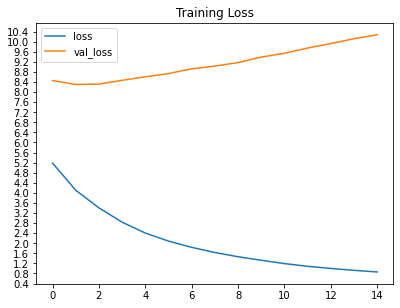

In [0]:
taken_data = 0 or input_tensors.size(0)

LOAD = False

RNN_TYPE = 'gru'
N_EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
SCHEDULER_STEP_SIZE = 10
SCHEDULER_GAMMA = 0.95
CLIP = 1

EXPERIMENT_NUMBER = 2
SAVE_PATH = f'{BASE_PATH}checkpoints/checkpoint_bi{RNN_TYPE}_{EXPERIMENT_NUMBER:03d}.tar'

try:
    checkpoint = torch.load(SAVE_PATH) if LOAD else None
except Exception as e:
    print(e)
    print(f'Unable to load checkpoint. Starting training from scratch.')
    checkpoint = None

INPUT_DIM = text_dict.n_words
OUTPUT_DIM = text_dict.n_words
# ENC_EMB_DIM = 256
# DEC_EMB_DIM = 256
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_N_LAYER = 2
DEC_N_LAYER = 2
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(pretrained_weight, feature_tensors, ENC_HID_DIM, DEC_HID_DIM, ENC_N_LAYER, ENC_DROPOUT, rnn_type=RNN_TYPE)
dec = Decoder(pretrained_weight, ENC_HID_DIM, DEC_HID_DIM, attn, DEC_N_LAYER, DEC_DROPOUT, rnn_type=RNN_TYPE)

seq2seq_model = Seq2Seq(enc, dec, PAD, device).to(device)
seq2seq_model.apply(init_weights)

print(f'The encoder has {count_n_parameters(seq2seq_model.encoder):,} trainable parameters')
print(f'The decoder has {count_n_parameters(seq2seq_model.decoder):,} trainable parameters')

plot_losses, val_plot_losses = trainIters(seq2seq_model,
                                          input_tensors[:taken_data], feature_tensors[:taken_data], target_tensors[:taken_data],
                                          input_val_tensors[:taken_data], feature_val_tensors[:taken_data], target_val_tensors[:taken_data],
                                          CLIP, BATCH_SIZE, N_EPOCHS, LEARNING_RATE, SCHEDULER_STEP_SIZE, SCHEDULER_GAMMA, checkpoint)
showPlot(plot_losses, val_plot_losses)

In [0]:
# !mv "/content/drive/My Drive/TA/checkpoints/checkpoint_bilstm_002b.tar" "/content/drive/My Drive/TA/checkpoints/checkpoint_bilstm_003.tar"

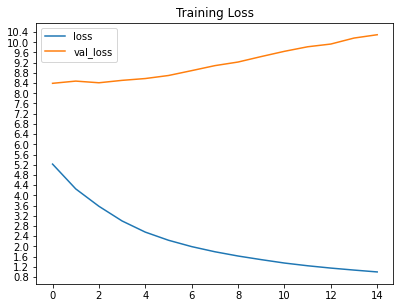

In [0]:
SAVE_PATH = f'{BASE_PATH}checkpoints/checkpoint_bilstm_{EXPERIMENT_NUMBER:03d}.tar'
checkpoint = torch.load(SAVE_PATH)
plot_losses = checkpoint['plot_losses']
val_plot_losses = checkpoint['val_plot_losses']
showPlot(plot_losses, val_plot_losses)

### Evaluate

In [0]:
def display_attention(sentence_, translation_, attention):
    sentence = sentence_.split()
    translation = translation_.split()
    
    fig = plt.figure(figsize=(30,30))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+[t.lower() for t in sentence], 
                       rotation=80)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.show()

In [0]:
def evaluate(model, input_tensor, feature_tensor, target_tensor, target_text):
    # input_tensor size = [src length, 1]
    # feature_tensor size = [src length, n_features]
    # target_tensor size = [src length, 1]
    model.eval()    
    with torch.no_grad():
        src_lengths = torch.sum(input_tensor != PAD, dim=0)
        src = input_tensor.unsqueeze(1)
        features = feature_tensor.unsqueeze(1)

        encoder_outputs, hidden = model.encoder(src, src_lengths, features)

        mask = model.create_mask(src)
        
        raw_decoder_output = torch.FloatTensor(size=(0, text_dict.n_words)).to(device)
        decoder_output = [SOS]

        attentions = torch.zeros(QUESTION_MAX_LENGTH, 1, SENTENCE_MAX_LENGTH).to(device)
    
        for i in range(QUESTION_MAX_LENGTH):
            trg = torch.LongTensor([decoder_output[-1]]).to(device)

            output, hidden, attention = model.decoder(trg, hidden, encoder_outputs, mask)

            attentions[i] = attention
                
            pred_token = output.argmax(1).item()
            
            raw_decoder_output = torch.cat((raw_decoder_output, output), dim=0)
            decoder_output.append(pred_token)

            if pred_token == EOS:
                break

        criterion = nn.CrossEntropyLoss(ignore_index=PAD)
        loss = criterion(
            raw_decoder_output[:-1,:], 
            target_tensor[1:raw_decoder_output.size(0)].view(-1)
            )

        decoded_words = [text_dict.index2word[idx] for idx in decoder_output[1:]]
    
    eval_score = calculate_eval_score(
        nlgeval,
        [clean_and_merge(target_text.split())],
        clean_and_merge(decoded_words)
    )

    return decoded_words, attentions[:len(decoded_words)-1], eval_score, loss

In [0]:
def do_evaluation(model, input_tensors, feature_tensors, target_tensors, n=10, randomized=True):
    chosen_idx = []
    # for j in range(n):
    for j in  [7999, 7382, 3766, 1135, 6693, 2968, 6182, 4186, 6785, 2833, 5705, 2964, 10064, 1122, 4104, 1663, 6110, 9171, 4094, 1153, 5077, 4455, 2932, 1295, 3817, 1520, 10159, 4559, 4483, 1959, 8694, 1097, 9210, 1323, 6161, 9304, 4903, 9499, 686, 6061, 2252, 3153, 10158, 8246, 10373, 438, 8501, 1821, 5133, 922, 541, 5698, 925, 7756, 10261, 1964, 9896, 1669, 2159, 2641, 9622, 4262, 6214, 4604]:
        i = j if not randomized else random.randint(0, input_tensors.size()[0])
        chosen_idx.append(i)
        print(i)
        input_tensor = input_tensors[i]
        feature_tensor = feature_tensors[i]
        target_tensor = target_tensors[i]
        is_answer_tensor = feature_tensor[:,0]
        input_text = ' '.join([text_dict.index2word[word_idx.item()] for word_idx in input_tensor])
        target_text = ' '.join([text_dict.index2word[word_idx.item()] for word_idx in target_tensor[1:]])
        answer_text = ' '.join([text_dict.index2word[input_tensor[idx].item()] if is_answer_tensor[idx]==1 else '' for idx in range(len(is_answer_tensor))]).strip()
        print('>', input_text)
        print('=', target_text)
        print('-', answer_text)
        output_text, attentions, eval_score, loss = evaluate(model, input_tensor, feature_tensor, target_tensor, target_text)
        output_sentence = ' '.join(output_text)
        print('<', output_sentence)
        print(f'Evaluation score: {eval_score}')
        print(f'Loss: {loss}')
        print()

        print('Attention')
        display_attention(input_text, output_sentence, attentions)
    return chosen_idx

#### BiLSTM

In [0]:
# do_evaluation(seq2seq_model, input_tensors, feature_tensors, target_tensors, n=16, randomized=False)
do_evaluation(seq2seq_model, input_test_tensors, feature_test_tensors, target_test_tensors, n=32, randomized=False)

#### BiGRU

In [0]:
# do_evaluation(seq2seq_model, input_tensors, feature_tensors, target_tensors, n=16, randomized=False)
do_evaluation(seq2seq_model, input_test_tensors, feature_test_tensors, target_test_tensors, n=32, randomized=False)

39621
> Didanai oleh pengusaha Somalia dan didukung oleh keahlian dari Cina , Korea dan Eropa , perusahaan telekomunikasi yang baru lahir ini menawarkan layanan telepon seluler dan internet yang terjangkau yang tidak tersedia di banyak bagian lain di benua ini . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
= Cina , Korea , dan Eropa meminjamkan apa untuk penciptaan perusahaan baru. <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
- keahlian
< Siapa yang dikendalikan negara Somalia ? <eos>
Evaluation score: {'Bleu_1': 0.0, 'Bleu_2': 0.0, 'Bleu_3': 0.0, 'Bleu_4': 0.0, 'METEOR': 0.0, 'ROUGE_L': 0.0}

Attention
72383
> Latihan Penilaian Penelitian 2008 juga menunjukkan lima mata pelajaran - Matematika Murni , Epidemiologi dan Kesehatan Masyarakat , Teknik Kimia , Teknik Sipil , dan Teknik Mekanik , Aeronautika dan Pabrikan - dinilai sebagai yang terbaik [ klarifikasi diperluk

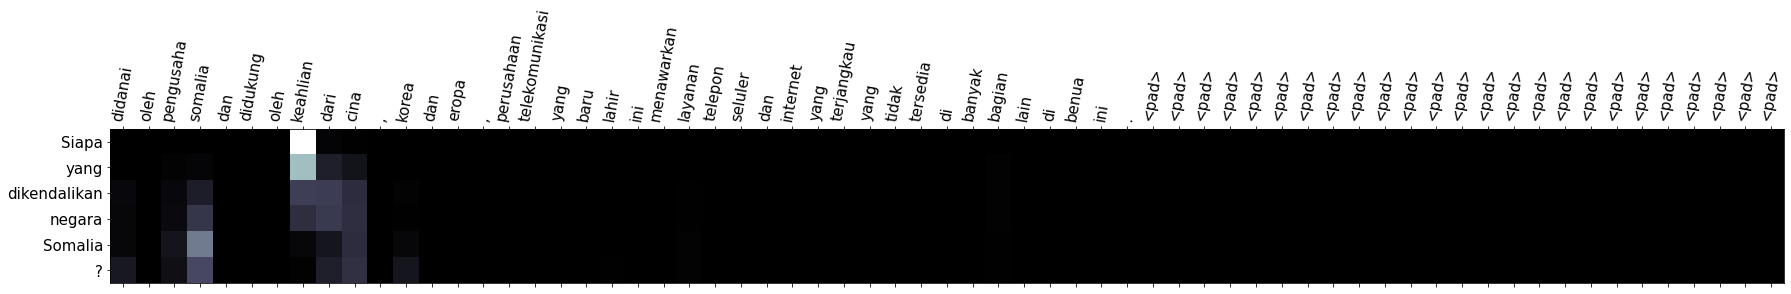

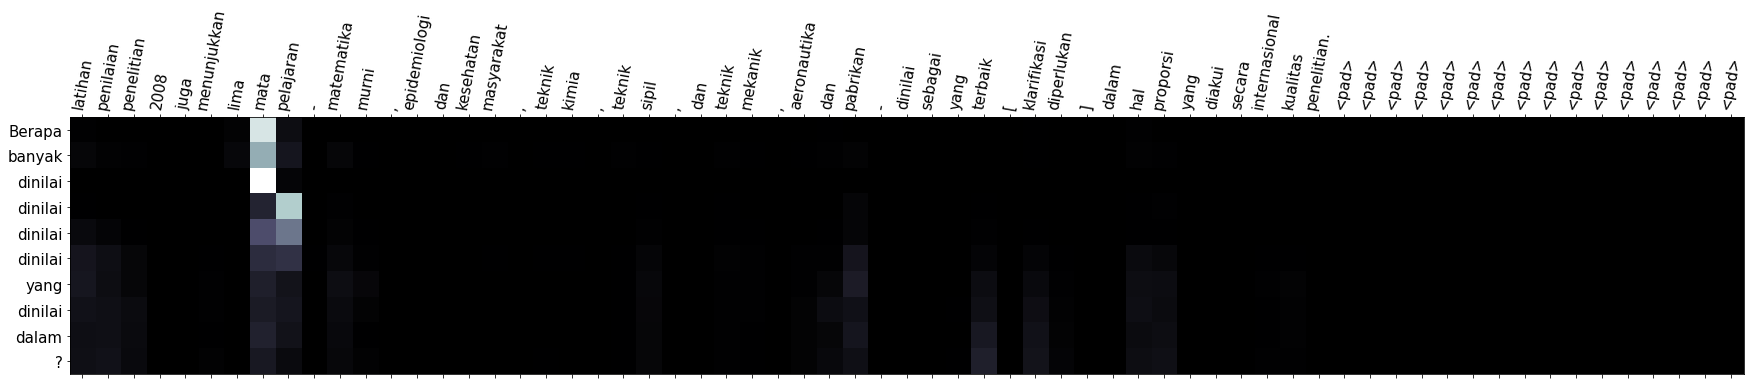

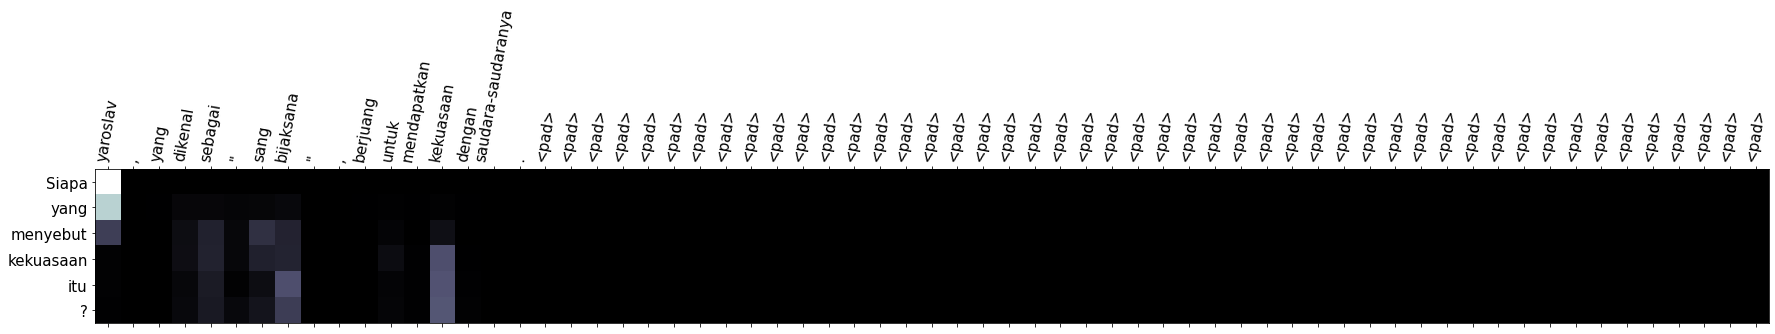

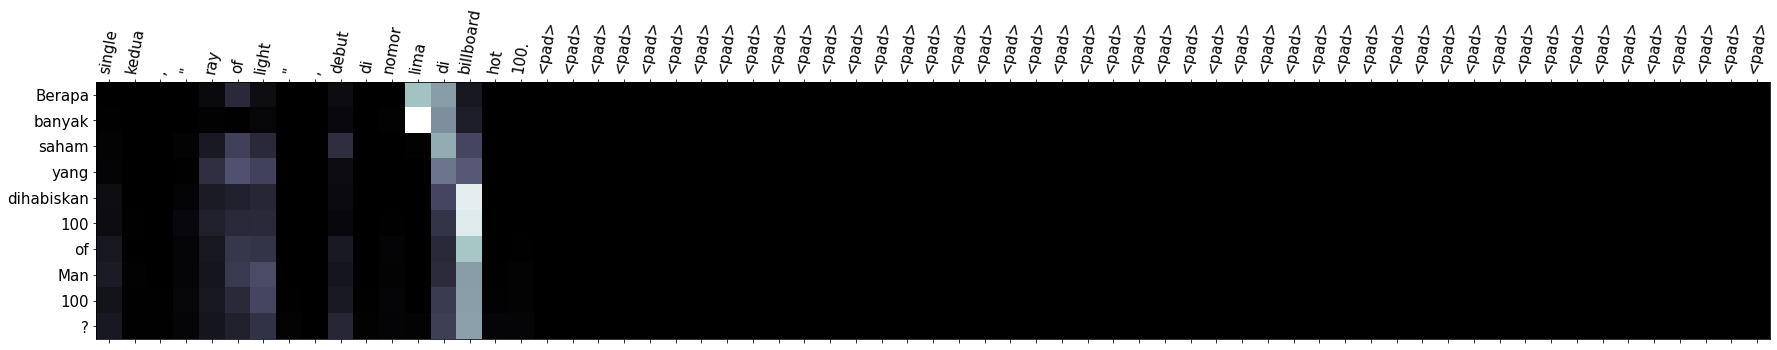

In [0]:
do_evaluation(seq2seq_model, n=4, randomized=True)

### Test

In [0]:
evaluations = []

start_time = time.time()
for i in range(input_test_tensors.size(0)):
    # input_tensor = input_tensors[i]
    # feature_tensor = feature_tensors[i]
    # target_tensor = target_tensors[i]
    # is_answer_tensor = feature_tensor[:,0]
    input_tensor = input_test_tensors[i]
    feature_tensor = feature_test_tensors[i]
    target_tensor = target_test_tensors[i]
    # is_answer_tensor = feature_tensor[:,0]
    
    input_text = ' '.join([text_dict.index2word[word_idx.item()] for word_idx in input_tensor])
    target_text = ' '.join([text_dict.index2word[word_idx.item()] for word_idx in target_tensor])
    # answer_text = ' '.join([text_dict.index2word[input_tensor[idx].item()] if is_answer_tensor[idx]==1 else '' for idx in range(len(is_answer_tensor))]).strip()
    # print('>', input_text)
    # print('=', target_text)
    # print('-', answer_text)
    output_text, _, eval_score, loss = evaluate(seq2seq_model, input_tensor, feature_tensor, target_tensor, target_text)
    output_sentence = ' '.join(output_text)
    evaluations.append(eval_score)
    # print('<', output_sentence)
    # print(f'BLEU score: {eval_score}')
    # print()
    if i % 500 == 0:
        print(f'{i}: {time.time()-start_time:.2f}s')

dict_mean(evaluations)

0: 0.04s
500: 13.97s
1000: 27.89s
1500: 41.61s
2000: 55.38s
2500: 69.20s
3000: 82.92s
3500: 96.56s
4000: 109.90s
4500: 123.72s
5000: 137.35s
5500: 151.75s
6000: 165.76s
6500: 180.42s
7000: 193.75s
7500: 206.86s
8000: 220.52s
8500: 233.74s
9000: 247.13s
9500: 260.77s
10000: 274.01s
10500: 287.61s


{'Bleu_1': 0.2019,
 'Bleu_2': 0.0493,
 'Bleu_3': 0.0083,
 'Bleu_4': 0.0016,
 'Bleu_avg': 0.0653,
 'METEOR': 0.0737,
 'ROUGE_L': 0.2344}

## Transformer

### LR Experiment

1 0.0002
2 0.0004
3 0.0006
4 0.0008
5 0.001
6 0.001
7 0.0009572050015330874
8 0.000905463412215599
9 0.0008362196501476349
10 0.0007525
11 0.000657963412215599
12 0.0005567415893174885
13 0.00045325841068251166
14 0.0003520365877844011
15 0.00025750000000000013
16 0.00017378034985236535
17 0.00010453658778440107
18 5.279499846691251e-05
19 2.0816937636766185e-05
20 1e-05


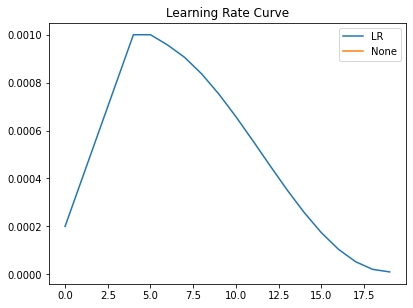

In [0]:
from torch import optim

model = [torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))]
optimizer = optim.Adam(model, 1e-3)

# scheduler_warmup is chained with schduler_steplr
# scheduler_steplr = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
scheduler_steplr = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-5)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler_steplr)

# this zero gradient update is needed to avoid a warning message, issue #8.
optimizer.zero_grad()
optimizer.step()

lr_plot = []
for epoch in range(1, 21):
    scheduler_warmup.step(epoch)
    print(epoch, optimizer.param_groups[0]['lr'])
    lr_plot.append(optimizer.param_groups[0]['lr'])

    optimizer.step()    # backward pass (update network)a
showPlot(lr_plot, title='Learning Rate Curve', label_1='LR', label_2='None')

### Model

In [0]:
from torch.nn import Transformer, Linear
import math

class TransformerModel(nn.Module):
    def __init__(self, pretrained_weight, feature_tensors, nhead, nlayers, nhid, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.feature_count = 0 if feature_tensors is None else feature_tensors.size(-1)
        self.src_mask = None
        self.tgt_mask = None
        self.memory_mask = None

        vocab_size, embedding_dim = pretrained_weight.size()
        self.embedding = nn.Embedding.from_pretrained(pretrained_weight)
        self.input_dim = embedding_dim + self.feature_count

        self.pos_encoding = PositionalEncoding(self.input_dim, dropout)
        self.transformer = Transformer(self.input_dim, nhead, nlayers, nlayers, nhid, dropout)
        self.linear = nn.Linear(self.input_dim, vocab_size)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask==1, float('-inf'))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def prepare_mask(self, data):
        mask = self._generate_square_subsequent_mask(len(data)).to(data.device)
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)

    def prepare_input(self, data, features=None):
        device = data.device
        if features is None or features.size(0) != self.feature_count:
            features = torch.zeros(()).new_full((data.size(0), data.size(1), self.feature_count), 0).to(device)
        # print('initial:', data.size())
        # print(features.size())
        data = self.embedding(data).view(data.size(0), data.size(1), -1)
        # print('embedded:', data.size())
        data = torch.cat((data, features), 2)
        # print('final:', data.size())
        data = data * math.sqrt(self.input_dim)
        return self.pos_encoding(data)

    def forward(self, src, features, tgt):
        # WARNING!!! THIS TRANSFORMER ACCEPT INPUT SHAPE AS (seq_length, batch_size, features)
        # print('src size:', src.size())
        # print('features size:', features.size())
        # print('tgt size:', tgt.size())

        # if self.src_mask is None or self.src_mask.size(0) != len(src):
        #     self.src_mask = self.prepare_mask(src)
        if self.tgt_mask is None or self.tgt_mask.size(0) != len(tgt):
            self.tgt_mask = self.prepare_mask(tgt)
            # print('tgt_mask:', self.tgt_mask.size())

        src_pad_mask = self.make_len_mask(src.squeeze(-1))
        # print('src_pad_mask:', src_pad_mask.size())
        tgt_pad_mask = self.make_len_mask(tgt.squeeze(-1))
        # print('tgt_pad_mask:', tgt_pad_mask.size())

        src = self.prepare_input(src, features)
        tgt = self.prepare_input(tgt)

        output = self.transformer(src, tgt, src_mask=self.src_mask, tgt_mask=self.tgt_mask, memory_mask=self.memory_mask,
                          src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask, memory_key_padding_mask=src_pad_mask)
        # print('output:', output.size())
        output = self.linear(output)
        # print('output linearized:', output.size())
        return output

In [0]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

#### Old v2

In [0]:
# from torch.nn import Transformer, Linear
# import math

# class TransformerModel(nn.Module):
#     def __init__(self, weights_matrix, feature_tensors, nhead, nlayers, nhid, dropout=0.5):
#         super(TransformerModel, self).__init__()
#         self.model_type = 'Transformer'
#         self.feature_count = 0 if feature_tensors is None else feature_tensors.size(-1)
#         self.src_mask = None
#         self.tgt_mask = None

#         self.embedding, vocab_size, embedding_dim = create_emb_layer(weights_matrix)
#         self.input_dim = embedding_dim + self.feature_count

#         self.pos_encoding = PositionalEncoding(self.input_dim, dropout)
#         self.transformer = Transformer(self.input_dim, nhead, nlayers, nlayers, nhid, dropout)
#         self.linear = nn.Linear(self.input_dim, vocab_size)

#         self.init_weights()

#     def _generate_square_subsequent_mask(self, sz):
#         mask = (torch.tril(torch.ones(sz, sz)) == 1)
#         mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#         return mask

#     def init_weights(self):
#         initrange = 0.1
#         self.linear.bias.data.zero_()
#         self.linear.weight.data.uniform_(-initrange, initrange)

#     def prepare_mask(self, data):
#         device = data.device
#         mask = self._generate_square_subsequent_mask(len(data)).to(device)
#         return mask

#     def prepare_input(self, data, features=None):
#         device = data.device
#         if features is None or features.size(0) != self.feature_count:
#             features = torch.zeros(()).new_full((data.size(0), data.size(1), self.feature_count), 0).to(device)
#         # print('initial:', data.size())
#         # print(features.size())
#         data = self.embedding(data).view(data.size(0), data.size(1), -1)
#         # print('embedded:', data.size())
#         data = torch.cat((data, features), 2).view(data.size(1), data.size(0), -1)
#         # print('final:', data.size())
#         data = data * math.sqrt(self.input_dim)
#         return self.pos_encoding(data)

#     def forward(self, src, features, tgt):
#         # if self.src_mask is None or self.src_mask.size(0) != len(src):
#         #     device = src.device
#         #     mask = self._generate_square_subsequent_mask(len(src)).to(device)
#         #     self.src_mask = mask
#         if self.tgt_mask is None or self.tgt_mask.size(0) != len(tgt):
#             device = tgt.device
#             mask = self._generate_square_subsequent_mask(len(tgt)).to(device)
#             self.tgt_mask = mask

#         tgt_has_sos = tgt[0,0,0] == SOS
#         if not tgt_has_sos:
#             # print('Now append <sos> at beginning of timestep')
#             sos_tensor = torch.zeros(()).new_full((tgt.size(0), 1, tgt.size(2)), SOS).long().to(tgt.device)
#             tgt = torch.cat((sos_tensor, tgt), 1)
#             # print([text_dict.index2word[idx] for idx in tgt.squeeze().cpu().tolist()])

#         src = self.prepare_input(src, features)
#         tgt = self.prepare_input(tgt)

#         output = self.transformer(src, tgt, src_mask=None, tgt_mask=self.tgt_mask)
#         # print('output:', output.size())
#         output = self.linear(output)
#         if not tgt_has_sos:
#             # print('Cutting last timestep output')
#             output = output[:-1,:,:]
#         # print('output linearized:', output.size())
#         return output

#### Old v1

In [0]:
# from torch.nn import TransformerEncoder, TransformerEncoderLayer
# import math

# class TransformerModel(nn.Module):
#     def __init__(self, weights_matrix, feature_tensors, nhead, nhid, nlayers, dropout=0.5):
#         super(TransformerModel, self).__init__()
#         self.model_type = 'Transformer'
#         self.src_mask = None

#         self.encoder, vocab_size, embedding_dim = create_emb_layer(weights_matrix)
#         self.input_dim = embedding_dim + feature_tensors.size(2)

#         self.pos_encoder = PositionalEncoding(self.input_dim, dropout)
#         encoder_layers = TransformerEncoderLayer(self.input_dim, nhead, nhid, dropout)
#         self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
#         self.decoder = nn.Linear(self.input_dim, vocab_size)

#         self.init_weights()

#     def _generate_square_subsequent_mask(self, sz):
#         mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
#         mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#         return mask

#     def init_weights(self):
#         initrange = 0.1
#         self.encoder.weight.data.uniform_(-initrange, initrange)
#         self.decoder.bias.data.zero_()
#         self.decoder.weight.data.uniform_(-initrange, initrange)

#     def forward(self, src, features):
#         if self.src_mask is None or self.src_mask.size(0) != len(src):
#             device = src.device
#             mask = self._generate_square_subsequent_mask(len(src)).to(device)
#             self.src_mask = mask

#         # print('initial:', src.size())
#         # print(features.size())
#         src = self.encoder(src).view(src.size(0), src.size(1), -1)
#         # print('embedded:', src.size())
#         src = torch.cat((src, features), 2)
#         # print('final:', src.size())
#         src = src * math.sqrt(self.input_dim)
#         src = self.pos_encoder(src)
#         output = self.transformer_encoder(src, self.src_mask)
#         # print('output:', output.size())
#         output = self.decoder(output)
#         return output

### Train

In [0]:
N_PRINT_IN_EPOCH = 20


def train_transformer(model, criterion, optimizer, train_data, feature_data, target_data, batch_size, curr_epoch, start_batch=1):
    model.train() # Turn on the train mode

    total_loss = 0.
    print_total_loss = 0.

    start_time = time.time()
    vocab_size = pretrained_weight.size(0)
    n_batch = math.ceil(len(train_data) / batch_size)
    log_interval = max(1, n_batch // N_PRINT_IN_EPOCH)
    for batch, i in enumerate(range((start_batch-1)*batch_size, train_data.size(0), batch_size), start_batch):
        data, features, targets = get_batch(train_data, feature_data, target_data, batch_size, i)
        src = data.permute(1, 0, 2)
        features = features.permute(1, 0, 2)
        targets = targets.permute(1, 0, 2)

        optimizer.zero_grad()
        output = model(src, features, targets)
        loss = criterion(
            output[:-1,:,:].reshape(-1, output.size(-1)),
            targets[1:,:,:].reshape(-1)
            )
        loss.backward()
        # total_batch_loss = 0.
        # i_end = min(i+batch_size, train_data.size(0))
        # for j in range(i, i_end):
        #     src = train_data[j].unsqueeze(1)
        #     features = None if feature_data is None else feature_data[j].unsqueeze(1)
        #     targets = target_data[j].unsqueeze(1)
        #     output = model(src, features, targets)
        #     loss = criterion(
        #         output[:-1,:,:].squeeze(),
        #         targets[1:,:,:].squeeze()
        #         )
        #     # loss, _ = feed_transformer(model, criterion, train_data[j], feature_data[j], target_data[j], is_training=True)
        #     loss.backward()
        #     total_batch_loss += loss.item()
        # print_total_loss += total_batch_loss / batch_size
        # total_loss += total_batch_loss / batch_size
        print_total_loss += loss.item()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        if batch % log_interval == 0:
            cur_loss = print_total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    curr_epoch, batch, n_batch, optimizer.param_groups[0]['lr'],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            # print('| epoch {:3d} | {:5d}/{:5d} batches | '
            #       'ms/batch {:5.2f} | '
            #       'loss {:5.2f} | ppl {:8.2f}'.format(
            #         curr_epoch, batch, n_batch,
            #         elapsed * 1000 / log_interval,
            #         cur_loss, math.exp(cur_loss)))
            print_total_loss = 0
            start_time = time.time()
    return total_loss / n_batch

def validate_transformer(eval_model, criterion, val_data, val_feature_data, val_target_data, batch_size):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    n_batch = math.ceil(len(val_data) / batch_size)
    with torch.no_grad():
        for i in range(0, val_data.size(0), batch_size):
            data, features, targets = get_batch(val_data, val_feature_data, val_target_data, batch_size, i)
            src = data.permute(1, 0, 2)
            features = features.permute(1, 0, 2)
            targets = targets.permute(1, 0, 2)

            output = eval_model(src, features, targets)
            loss = criterion(
                output[:-1,:,:].reshape(-1, output.size(-1)),
                targets[1:,:,:].reshape(-1)
                )
            total_loss += loss.item()
            # i_end = min(i+batch_size, val_data.size(0))
            # for j in range(i, i_end):
            #     src = val_data[j].unsqueeze(1)
            #     features = None if val_feature_data is None else val_feature_data[j].unsqueeze(1)
            #     targets = val_target_data[j].unsqueeze(1)
            #     output = eval_model(src, features, targets)
            #     loss = criterion(
            #         output[:-1,:,:].squeeze(),
            #         targets[1:,:,:].squeeze()
            #         )
            #     total_loss += loss.item()
    # return total_loss / (len(val_data) - 1)
    return total_loss / n_batch

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [0]:
SAVE_FREQUENCY = 10


def trainIters_transformer(model, input_tensors, feature_tensors, target_tensors, input_val_tensors, feature_val_tensors, target_val_tensors, batch_size, epochs, learning_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.95, checkpoint=None):
    # best_val_loss = float("inf")
    # best_model = None
    start_epoch = 1
    start_batch = 1
    plot_losses = []
    val_plot_losses = []

    criterion = nn.CrossEntropyLoss(ignore_index=PAD)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, scheduler_step_size, scheduler_gamma)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=learning_rate/100)
    scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler)
    
    # this zero gradient update is needed to avoid a warning message, issue #8.
    optimizer.zero_grad()
    optimizer.step()

    if checkpoint is not None:
        start_epoch = checkpoint['next_epoch']
        plot_losses = checkpoint['plot_losses']
        val_plot_losses = checkpoint['val_plot_losses']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # optimizer.param_groups[0]['lr'] = learning_rate
        scheduler.load_state_dict(checkpoint['scheduler'])
        scheduler_warmup.load_state_dict(checkpoint['scheduler_warmup'])

    print(f'Starting from epoch-{start_epoch}')
    for epoch in range(start_epoch, epochs + 1):
        epoch_start_time = time.time()
        scheduler_warmup.step(epoch)

        avg_loss = train_transformer(
            model, criterion, optimizer, \
            input_tensors, feature_tensors, target_tensors, \
            batch_size=batch_size, curr_epoch=epoch, start_batch=start_batch
            )
        val_loss = validate_transformer(model, criterion, input_val_tensors, feature_val_tensors, target_val_tensors, batch_size)
        plot_losses.append(avg_loss)
        val_plot_losses.append(val_loss)
        start_batch = 1
        print('-' * 98)
        print('| end of epoch {:3d} | time: {:5.2f}s | avg loss {:5.2f} | valid loss {:5.2f} | '
              'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time), avg_loss, val_loss, math.exp(val_loss)))
        # print('| end of epoch {:3d} | time: {:5.2f}s | avg loss {:5.2f} | avg ppl {:8.2f}' \
        #       .format(epoch, (time.time() - epoch_start_time), avg_loss, math.exp(avg_loss)))
        print('-' * 98)

        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     best_model = model

        # scheduler.step()

        if epoch == epochs or (SAVE_FREQUENCY != -1 and epoch % SAVE_FREQUENCY == 0):
            print('Saving model..')
            torch.save({
                'next_epoch': epoch + 1,
                'plot_losses': plot_losses,
                'val_plot_losses': val_plot_losses,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'scheduler_warmup': scheduler_warmup.state_dict(),
            }, SAVE_PATH_TRANSFORMER)

    return plot_losses, val_plot_losses

### Start Training

Transformer Parameters: 
Encoder: 1057216
Decoder: 1800192
Starting from epoch-1


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


| epoch   1 |    72/ 1456 batches | lr 0.0002000000 | ms/batch 64.26 | loss  8.00 | ppl  2966.81
| epoch   1 |   144/ 1456 batches | lr 0.0002000000 | ms/batch 64.11 | loss  6.39 | ppl   593.72
| epoch   1 |   216/ 1456 batches | lr 0.0002000000 | ms/batch 64.17 | loss  6.15 | ppl   469.58
| epoch   1 |   288/ 1456 batches | lr 0.0002000000 | ms/batch 64.05 | loss  6.03 | ppl   416.05
| epoch   1 |   360/ 1456 batches | lr 0.0002000000 | ms/batch 64.07 | loss  5.97 | ppl   390.33
| epoch   1 |   432/ 1456 batches | lr 0.0002000000 | ms/batch 64.22 | loss  5.89 | ppl   362.48
| epoch   1 |   504/ 1456 batches | lr 0.0002000000 | ms/batch 64.19 | loss  5.81 | ppl   332.49
| epoch   1 |   576/ 1456 batches | lr 0.0002000000 | ms/batch 64.17 | loss  5.79 | ppl   326.69
| epoch   1 |   648/ 1456 batches | lr 0.0002000000 | ms/batch 64.04 | loss  5.75 | ppl   315.09
| epoch   1 |   720/ 1456 batches | lr 0.0002000000 | ms/batch 64.07 | loss  5.69 | ppl   295.92
| epoch   1 |   792/ 1456 batc

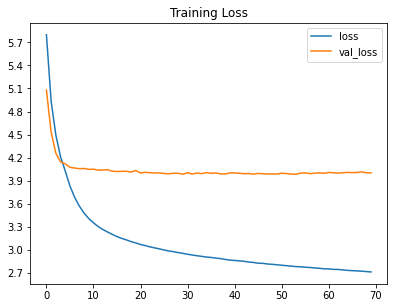

In [0]:
EXPERIMENT_NUMBER = 5
SAVE_PATH_TRANSFORMER = f'{BASE_PATH}checkpoints/checkpoint_transformer_{EXPERIMENT_NUMBER:03d}.tar'

LOAD = False
nhid = 256 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.3 # the dropout value


N_EPOCHS = 70
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
SCHEDULER_STEP_SIZE = 1
SCHEDULER_GAMMA = 0.995

try:
    checkpoint = torch.load(SAVE_PATH_TRANSFORMER) if LOAD else None
except Exception as e:
    print(f'Unable to load checkpoint. Starting training from scratch.')
    checkpoint = None

transformer_model = TransformerModel(pretrained_weight, feature_tensors, nhead, nlayers, nhid, dropout).to(device)
print(f'Transformer Parameters: ')
print(f'Encoder: {count_n_parameters(transformer_model.transformer.encoder)}')
print(f'Decoder: {count_n_parameters(transformer_model.transformer.decoder)}')
taken_data = 0 or input_tensors.size(0)
plot_losses, val_plot_losses = trainIters_transformer(transformer_model,
                                                      input_tensors[:taken_data], feature_tensors[:taken_data], target_tensors[:taken_data],
                                                      input_val_tensors[:taken_data], feature_val_tensors[:taken_data], target_val_tensors[:taken_data],
                                                      BATCH_SIZE, N_EPOCHS, LEARNING_RATE, SCHEDULER_STEP_SIZE, SCHEDULER_GAMMA, checkpoint)
# dummy_inp = torch.ones(16, SENTENCE_MAX_LENGTH, 1).long().to(device)
# dummy_feat = torch.ones(16, SENTENCE_MAX_LENGTH, 4).long().to(device)
# dummy_targ = torch.ones(16, QUESTION_MAX_LENGTH, 1).long().to(device)
# history = trainIters_transformer(transformer_model, dummy_inp, dummy_feat, dummy_targ, BATCH_SIZE, N_EPOCHS, LEARNING_RATE, SCHEDULER_STEP_SIZE, SCHEDULER_GAMMA, checkpoint)
showPlot(plot_losses, val_plot_losses)

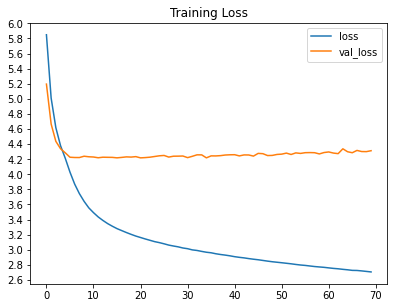

In [0]:
checkpoint = torch.load(SAVE_PATH_TRANSFORMER)
plot_losses = checkpoint['plot_losses']
val_plot_losses = checkpoint['val_plot_losses']
showPlot(plot_losses, val_plot_losses)

In [0]:
# !cp "/content/drive/My Drive/TA/checkpoints/checkpoint_transformer.tar" "/content/drive/My Drive/TA/checkpoints/checkpoint_transformer_001.tar"
!cp "/content/drive/My Drive/TA/checkpoints/checkpoint_transformer_004.tar" "/content/drive/My Drive/TA/checkpoints/checkpoint_transformer_004b.tar"

### Evaluate

In [0]:
def evaluate_transformer(model, input_tensor, feature_tensor, target_tensor, parallel=False):
    model.eval()
    with torch.no_grad():
        target_length = target_tensor.size(0)

        src = input_tensor.unsqueeze(1)
        features = feature_tensor.unsqueeze(1)
        tgt = target_tensor.unsqueeze(1)
        
        if parallel:
            out = model(src, features, tgt)
            criterion = nn.CrossEntropyLoss(ignore_index=PAD)
            loss = criterion(
                out[:-1,:,:].squeeze(), 
                tgt[1:,:,:].squeeze()
                )
            print('Loss:', loss.item())
            
            out = F.softmax(out, dim=-1)
            topv, topi = out.data.topk(1)
            # print('Input:', decoder_input)
            # print('Topi:', topi.squeeze().data.tolist())
            # print(topi.size())
            # print()
            decoded_words = [text_dict.index2word[idx] for idx in topi.squeeze().data.tolist()]

        else:
            src_pad_mask = model.make_len_mask(src.squeeze(-1))
            tgt_pad_mask = model.make_len_mask(tgt.squeeze(-1))

            src = model.prepare_input(src, features)
            memory = model.transformer.encoder(src, mask=None, src_key_padding_mask=src_pad_mask)

            decoded_words = []
            decoder_input = torch.zeros(()).new_full((target_length, 1, 1), PAD).long().to(tgt.device)
            decoder_input[0,0,0] = tgt[0,0,0]
            tgt_mask = model.prepare_mask(tgt)
            for i in range(target_length-1):
                # print([text_dict.index2word[word_idx] for word_idx in decoder_input.squeeze().cpu().tolist()])
                tgt = model.prepare_input(decoder_input)
                out = model.transformer.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=None,
                                                tgt_key_padding_mask=tgt_pad_mask,
                                                memory_key_padding_mask=src_pad_mask)
                out = model.linear(out)
                out = F.softmax(out.squeeze(), dim=-1)
                topv, topi = out.data.topk(1)
                # print('Input:', decoder_input)
                # print('Topi:', topi.squeeze().data.tolist())
                # print()
                prediction = topi[i][0].item()
                decoded_words.append(text_dict.index2word[prediction])
                decoder_input[i+1,0,0] = prediction
                # print(prediction)
                if prediction == EOS:
                    break

        target_text = ' '.join([text_dict.index2word[word_idx.item()] for word_idx in target_tensor[1:].squeeze(0)])
        eval_score = calculate_eval_score(
            nlgeval,
            [clean_and_merge(target_text.split())],
            clean_and_merge(decoded_words)
        )

        return decoded_words, eval_score

def do_evaluation_transformer(model, input_tensors, feature_tensors, target_tensors, n=10, randomized=True):
    assert n <= input_tensors.size(0)
    chosen_idx = []
    for j in range(n):
        i = j if not randomized else random.randint(0, input_tensors.size()[0])
        chosen_idx.append(i)
        print(i)
        input_tensor = input_tensors[i]
        feature_tensor = feature_tensors[i]
        target_tensor = target_tensors[i]
        is_answer_tensor = feature_tensor[:,0]
        input_text = ' '.join([text_dict.index2word[word_idx.item()] for word_idx in input_tensor])
        target_text = ' '.join([text_dict.index2word[word_idx.item()] for word_idx in target_tensor[1:]])
        answer_text = ' '.join([text_dict.index2word[input_tensor[idx].item()] if is_answer_tensor[idx]==1 else '' for idx in range(len(is_answer_tensor))]).strip()
        print('>', input_text)
        print('=', target_text)
        print('-', answer_text)
        output_text, eval_score = evaluate_transformer(model, input_tensor, feature_tensor, target_tensor)
        output_sentence = ' '.join(output_text)
        print('<', output_sentence)
        print(f'Evaluation: {eval_score}')
        print('')
    return chosen_idx

In [0]:
# do_evaluation_transformer(transformer_model, input_tensors, feature_tensors, target_tensors, n=32, randomized=False)
do_evaluation_transformer(transformer_model, input_test_tensors, feature_test_tensors, target_test_tensors, n=64, randomized=True)

6065
> Untuk memperbaiki sebagian kesenjangan kekayaan dan pertumbuhan yang lambat , S & P merekomendasikan peningkatan akses ke pendidikan . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
= Apa yang direkomendasikan Standard & Poor untuk mempercepat pemulihan ekonomi ? <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
- peningkatan akses ke pendidikan
< Apa yang tidak boleh dilakukan oleh hambatan untuk meningkatkan minat ekonomi ? <eos>
Evaluation: {'Bleu_1': 0.4167, 'Bleu_2': 0.2752, 'Bleu_3': 0.0, 'Bleu_4': 0.0, 'METEOR': 0.1894, 'ROUGE_L': 0.4382, 'Bleu_avg': 0.172975}

5820
> <unk> of the Brick Church pada 1862 tepat di luar Jacksonville menghasilkan kemenangan Konfederasi pertama di Florida . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

[6065,
 5820,
 3432,
 4374,
 1169,
 9980,
 10403,
 2803,
 8751,
 4010,
 2677,
 7573,
 6216,
 4422,
 10485,
 9125,
 3598,
 5313,
 916,
 3752,
 525,
 5168,
 6572,
 4386,
 1084,
 3456,
 9292,
 5155,
 3483,
 8179,
 6482,
 10532,
 7517,
 2340,
 4339,
 2287,
 4040,
 9197,
 8830,
 4304,
 9577,
 7019,
 9560,
 6543,
 5930,
 3593,
 2266,
 8348,
 8085,
 1489,
 771,
 1796,
 2504,
 10280,
 2621,
 6916,
 9771,
 1040,
 6304,
 6252,
 9763,
 7668,
 8669,
 4119]

In [0]:
evaluations = []

start_time = time.time()
for i in range(input_test_tensors.size(0)):
    # input_tensor = input_tensors[i]
    # feature_tensor = feature_tensors[i]
    # target_tensor = target_tensors[i]
    # is_answer_tensor = feature_tensor[:,0]
    input_tensor = input_test_tensors[i]
    feature_tensor = feature_test_tensors[i]
    target_tensor = target_test_tensors[i]
    # is_answer_tensor = feature_tensor[:,0]
    
    input_text = ' '.join([text_dict.index2word[word_idx.item()] for word_idx in input_tensor])
    target_text = ' '.join([text_dict.index2word[word_idx.item()] for word_idx in target_tensor])
    # answer_text = ' '.join([text_dict.index2word[input_tensor[idx].item()] if is_answer_tensor[idx]==1 else '' for idx in range(len(is_answer_tensor))]).strip()
    # print('>', input_text)
    # print('=', target_text)
    # print('-', answer_text)
    output_text, eval_score = evaluate_transformer(transformer_model, input_tensor, feature_tensor, target_tensor)
    output_sentence = ' '.join(output_text)
    evaluations.append(eval_score)
    # print('<', output_sentence)
    # print(f'BLEU score: {eval_score}')
    # print()
    if i % 500 == 0:
        print(f'{i}: {time.time()-start_time:.2f}s')

dict_mean(evaluations)

0: 0.03s
500: 21.69s
1000: 43.65s
1500: 63.72s
2000: 84.55s
2500: 105.32s
3000: 126.93s
3500: 147.69s
4000: 168.51s
4500: 189.70s
5000: 210.76s
5500: 232.72s
6000: 254.59s
6500: 276.97s
7000: 297.01s
7500: 316.16s
8000: 337.00s
8500: 356.25s
9000: 376.22s
9500: 395.37s
10000: 414.42s
10500: 434.59s


{'Bleu_1': 0.2248,
 'Bleu_2': 0.058,
 'Bleu_3': 0.0122,
 'Bleu_4': 0.0028,
 'Bleu_avg': 0.0744,
 'METEOR': 0.0949,
 'ROUGE_L': 0.259}